In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300

## True forecast covariance

In [2]:
N = 100
d1 = 1
d2 = 8
Pt = np.eye(N)
for i in range(N):
    for j in range(N):
        Pt[i,j] = np.sqrt(i*j/N/N)*np.exp(-0.5*((i-j)/d1)**2) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*np.exp(-0.5*((i-j)/d2)**2) 

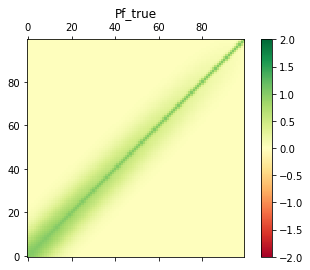

In [3]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
cmap = 'RdYlGn'
fig, ax = plt.subplots()
mappable = ax.matshow(Pt, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title('Pf_true')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig('Pf_true.pdf')
plt.show()

In [4]:
from scipy.linalg import eigh, norm
eigs, eigv = eigh(Pt)
sPt = eigv @ np.diag(np.sqrt(eigs))
print(sPt.shape)
print(norm(Pt - sPt@sPt.transpose()))

(100, 100)
6.341124912457197e-14


## localization matrix

In [5]:
d1 = 1*3.0
d2 = 8*3.0
Ftilde = np.eye(N)
for i in range(N):
    for j in range(N):
        Ftilde[i,j] = np.sqrt(i*j/N/N)*np.exp(-0.5*((i-j)/d1)**2) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*np.exp(-0.5*((i-j)/d2)**2) 
eigs, eigv = eigh(Ftilde)
neig = 1
thres = 0.85
frac = 0.0
while frac < thres:
    frac = eigs[N-neig:N].sum() / eigs.sum()
    neig += 1
print(neig)
Wtilde = eigv[:,N-neig:N] @ np.diag(np.sqrt(eigs[N-neig:N]))
Flow = Wtilde @ Wtilde.transpose()

11


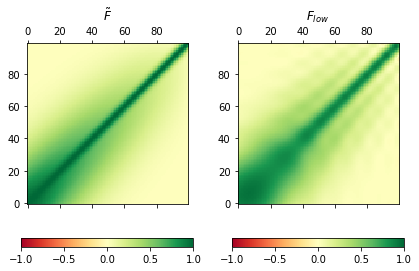

In [6]:
fig, ax = plt.subplots(1,2)
mappable = ax[0].matshow(Ftilde, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax[0].invert_yaxis()
ax[0].set_title(r'$\tilde{F}$')
fig.colorbar(mappable, ax=ax[0], orientation='horizontal')
mappable = ax[1].matshow(Flow, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax[1].invert_yaxis()
ax[1].set_title(r'$F_{low}$')
fig.colorbar(mappable, ax=ax[1], orientation='horizontal')
fig.tight_layout()
plt.show()

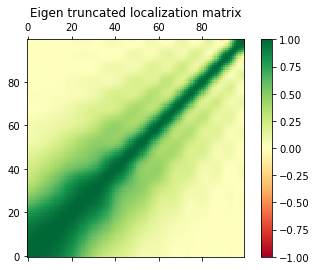

In [7]:
W = Wtilde
diagF = np.diag(Flow)
for i in range(W.shape[0]):
    W[i, :] /= np.sqrt(diagF[i])
F = W @ W.transpose()
fig, ax = plt.subplots()
mappable = ax.matshow(F, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax.invert_yaxis()
ax.set_title(f'Eigen truncated localization matrix')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'locmat.pdf')
plt.show()

In [8]:
def calc_dist(i):
    d1 = 1
    d2 = 8
    dist = np.zeros(N)
    for j in range(N):
        dist[j] = np.sqrt(i*j/N/N)*(np.fabs(i-j)/d1) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*(np.fabs(i-j)/d2) 
    return dist

def calc_dist1(i,j):
    d1 = 1
    d2 = 8
    dist = np.sqrt(i*j/N/N)*(np.fabs(i-j)/d1) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*(np.fabs(i-j)/d2) 
    return dist

## Observation operator and error covariance

In [9]:
class Obs():
    def __init__(self, operator, sigma,Pt):
        self.operator=operator
        self.sigma=sigma
        self.Pt = Pt
        logger.info(f"operator={self.operator}, sigma={self.sigma}")
    
    def get_op(self):
        return self.operator
    
    def get_sig(self):
        return self.sigma
        
    def set_r(self, N):
        from scipy.linalg import inv
        oberrstdev = self.sigma
        oberrvar = oberrstdev**2
        H = self.dh_operator(np.arange(N), np.zeros(N))
        HPHt = H @ self.Pt @ H.transpose()
        R = oberrvar * np.diag(np.diag(HPHt))
        Rsqrt = oberrstdev * np.diag(np.sqrt(np.diag(HPHt)))
        Rsqrtinv = inv(Rsqrt)
        Rinv = Rsqrtinv.transpose() @ Rsqrtinv
        return R, Rsqrtinv, Rinv
    
    def dh_operator(self, obsloc, x):
        p = obsloc.size
        n = x.size
        H = np.zeros((p,n))
        logger.debug(f"H={H.shape}")
        smooth_len = 4.0
        for j in range(p):
            for i in range(n):
                rr = float(i)-obsloc[j]
                r = np.fabs(rr) / smooth_len
                H[j,i] = np.exp(-r**2)
            H[j,:] = H[j,:]/H[j,:].sum()
        return H
    
    def h_operator(self,obsloc,x):
        if x.ndim > 1:
            hx = self.dh_operator(obsloc,x[:,0]) @ x
        else:
            hx = self.dh_operator(obsloc,x) @ x
        logger.debug(f"hx={hx.shape}")
        return hx

In [10]:
import logging
from logging.config import fileConfig
fileConfig('logging_config.ini')
logger = logging.getLogger('anl')
oberrstdev = 1.0 / 8.0
obs = Obs('vint', oberrstdev,Pt)

2021-08-31 17:25:07,248 anl INFO operator=vint, sigma=0.125


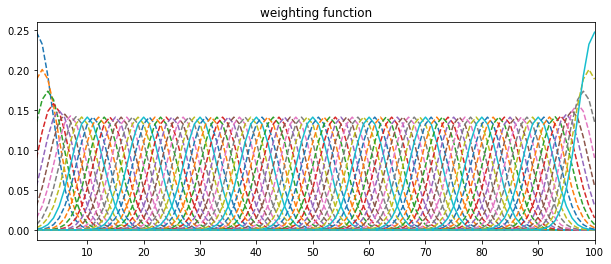

In [11]:
p = N #observed all grid
H = obs.dh_operator(np.arange(p), np.zeros(N))
vindex = np.arange(1,p+1)
fig, ax = plt.subplots(figsize=(10,4))
for j in range(p):
    if np.mod(j+1,10) == 0:
        linestyle='solid'
    else:
        linestyle='dashed'
    ax.plot(vindex,H[j], linestyle=linestyle)
ax.set_xlim(vindex[0],vindex[-1])
ax.set_xticks(vindex[9::10])
ax.set_title('weighting function')
#fig.savefig('Hrow.pdf')
plt.show()

(100, 100) (100, 100) (100, 100)
1.6063764188150566e-17
0.0


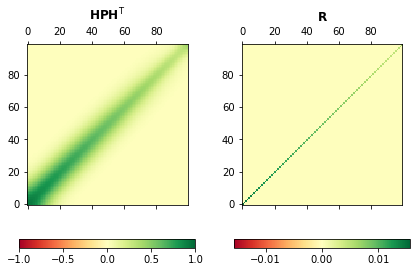

In [12]:
from scipy.linalg import inv
H = obs.dh_operator(np.arange(N), np.zeros(N))
oberrvar = obs.get_sig()**2
HPHt = H @ Pt @ H.transpose()
R, Rsqrtinv, Rinv = obs.set_r(N)
print(R.shape, Rsqrtinv.shape, Rinv.shape)
Rsqrt = inv(Rsqrtinv)
print(norm(R - Rsqrt@Rsqrt))
print(norm(Rinv - Rsqrtinv@Rsqrtinv))
fig, ax = plt.subplots(1,2)
mappable = ax[0].matshow(HPHt, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax[0].invert_yaxis()
ax[0].set_title(r"$\mathbf{H}\mathbf{P}\mathbf{H}^\mathrm{T}$")
fig.colorbar(mappable, ax=ax[0], orientation='horizontal')
mappable = ax[1].matshow(R, cmap=cmap, norm=Normalize(vmin=-oberrvar, vmax=oberrvar))
ax[1].invert_yaxis()
ax[1].set_title(r"$\mathbf{R}$")
fig.colorbar(mappable, ax=ax[1], orientation='horizontal')
fig.tight_layout()
plt.show()

## Varidation

In [13]:
def mse(Pa_app):
    diff = np.zeros_like(Pa_app)
    for j in range(N):
        for i in range(N):
            diff[j,i] = (Pa_app[j,i] - Pat[j,i])**2
    diff = F * diff
    mse = diff.sum()
    mse /= N**2
    return mse

def corr(Pa_app):
    tmp = Pa_app**2
    var1 = tmp.sum()
    tmp = Pat**2
    var2 = tmp.sum()
    tmp = Pa_app * Pat
    cov = tmp.sum()
    corr = cov / np.sqrt(var1) / np.sqrt(var2)
    return corr

## Lists for storing results and counter

In [14]:
xrmse_mean = []
mse_mean = []
corr_mean = []
ntest = 0

### Test

## Random seed

In [159]:
rs = np.random.RandomState() #variable
rstrue = np.random.RandomState(514) #fix

## True state and observation

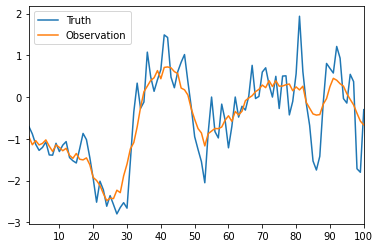

In [160]:
xt = sPt @ rstrue.standard_normal(size=N)
y = obs.dh_operator(np.arange(p), xt) @ xt + Rsqrt @ rs.standard_normal(size=p)
plt.plot(vindex, xt, label='Truth')
plt.plot(vindex, y, label='Observation')
plt.xticks(vindex[9::10])
plt.xlim(vindex[0],vindex[-1])
plt.legend()
#plt.savefig('true_obs.pdf')
plt.show()

## Forecast ensemble

In [161]:
K = 50
Xf = rs.standard_normal(size=(N,K))
Xf = sPt @ Xf
Xf = Xf - Xf.mean(axis=1)[:, None]
Pe = Xf @ Xf.transpose() / (K-1)
err = norm(Pt - Pe)
print(err)

14.868327881027783


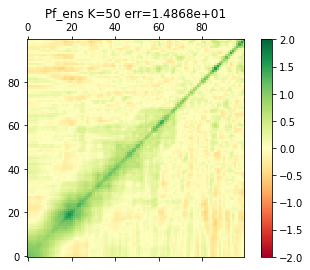

In [162]:
fig, ax = plt.subplots()
mappable = ax.matshow(Pe, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title(f'Pf_ens K={K} err={err:.4e}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pf_ens_{K}.pdf')
plt.show()

7.686717224602986


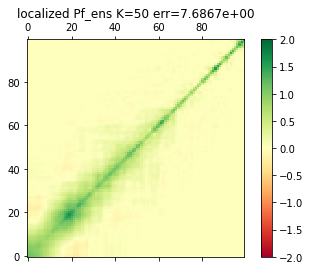

In [163]:
Ploc = Pe * F
err = norm(Pt - Ploc)
print(err)

fig, ax = plt.subplots()
mappable = ax.matshow(Ploc, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title(f'localized Pf_ens K={K} err={err:.4e}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pf_locens_{K}.pdf')
plt.show()

(100, 50)


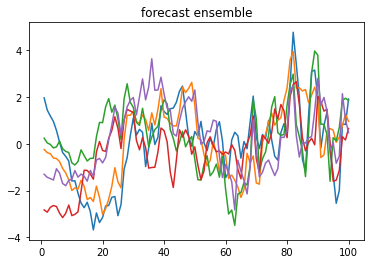

In [164]:
# forecast ensemble
## mean
xf_ = sPt @ rs.standard_normal(size=N)
## member
xf = xf_[:, None] + Xf
print(xf.shape)
for k in range(0,K,10):
    plt.plot(vindex, xf[:,k])
plt.title('forecast ensemble')
plt.show()

7.686717224602986


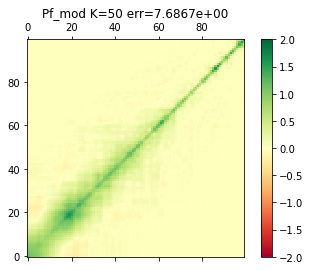

In [165]:
# modulated ensemble
L = W.shape[1]
M = K*L
Xfm = np.empty((N, M), Xf.dtype)
for l in range(L):
    for k in range(K):
        m = l*K + k
        Xfm[:, m] = W[:, l] * Xf[:, k]
Xfm *= np.sqrt((M-1)/(K-1))
Pmod = Xfm @ Xfm.transpose() / (M-1)
err = norm(Pt - Pmod)
print(err)

fig, ax = plt.subplots()
mappable = ax.matshow(Pmod, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title(f'Pf_mod K={K} err={err:.4e}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pf_modens_{K}.pdf')
plt.show()

In [166]:
# compute true analysis error covariance for modulated ensemble
Htilde = Rsqrtinv @ obs.dh_operator(np.arange(p), xf_)
Z = Xfm / np.sqrt(M-1)
HZ = Htilde @ Z
A = HZ.transpose() @ HZ
eigs, eigv = eigh(A)
Dsqrt = np.sqrt(1.0/(1.0+eigs))
T = eigv @ np.diag(Dsqrt) @ eigv.transpose()
Za = Z @ T
Kmat = Za @ Za.transpose() @ Htilde.transpose()

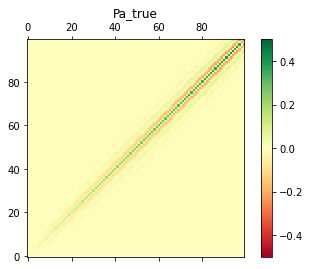

In [167]:
KHP = Kmat @ Htilde @ Pt
Pat = Pt - KHP - KHP.transpose() + Kmat@(Htilde@Pt@Htilde.transpose()+np.eye(p))@Kmat.transpose()
fig, ax = plt.subplots()
mappable = ax.matshow(Pat, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
ax.invert_yaxis()
ax.set_title('Pa_true')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig('Pa_true.pdf')
plt.show()

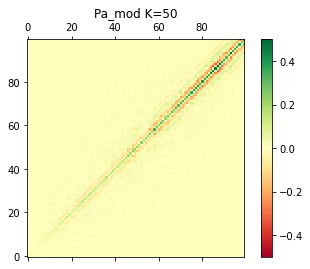

In [168]:
Pam = Za @ Za.transpose()
fig, ax = plt.subplots()
mappable = ax.matshow(Pam, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
ax.invert_yaxis()
ax.set_title(f'Pa_mod K={K}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pa_modens_{K}.pdf')
plt.show()

## EnKF

2021-08-31 17:35:06,511 anl INFO model : model
2021-08-31 17:35:06,512 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:06,512 anl INFO linf=False iloc=None ltlm=False
2021-08-31 17:35:06,570 anl INFO set R
2021-08-31 17:35:06,624 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:06,802 anl INFO save_dh=False cycle0
2021-08-31 17:35:06,980 anl INFO converge gmat, iter_num=3, norm=4.595788570545217e-07
2021-08-31 17:35:06,982 anl INFO err=0.3446472520451578
2021-08-31 17:35:06,984 anl INFO dof=0.5977779276659755


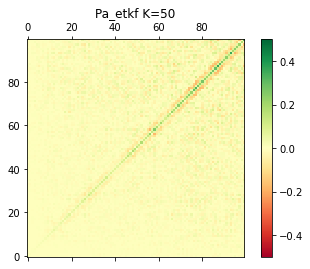

2021-08-31 17:35:07,175 anl INFO model : model
2021-08-31 17:35:07,176 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:07,176 anl INFO linf=False iloc=2 ltlm=False
2021-08-31 17:35:07,238 anl INFO set R
2021-08-31 17:35:07,301 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:07,302 anl INFO ==B-localization==, lsig=3.0
2021-08-31 17:35:07,302 anl INFO == modulated ensemble, nmode=11 ==
2021-08-31 17:35:07,307 anl INFO dxf.shape=(100, 550)
2021-08-31 17:35:07,624 anl INFO save_dh=False cycle0
2021-08-31 17:35:07,686 anl INFO random sampling
2021-08-31 17:35:07,695 anl INFO standard deviation ratio = 0.9984238965018642
2021-08-31 17:35:07,926 anl INFO converge gmat, iter_num=2, norm=1.350379792782122e-06
2021-08-31 17:35:07,935 anl INFO err=1.5049733877000189
2021-08-31 17:35:07,953 anl INFO dof=0.727558125610167


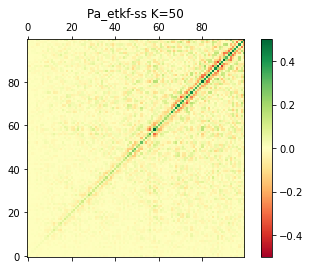

2021-08-31 17:35:08,153 anl INFO model : model
2021-08-31 17:35:08,153 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:08,154 anl INFO linf=False iloc=2 ltlm=False
2021-08-31 17:35:08,216 anl INFO set R
2021-08-31 17:35:08,270 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:08,271 anl INFO ==B-localization==, lsig=3.0
2021-08-31 17:35:08,271 anl INFO == modulated ensemble, nmode=11 ==
2021-08-31 17:35:08,275 anl INFO dxf.shape=(100, 550)
2021-08-31 17:35:08,583 anl INFO save_dh=False cycle0
2021-08-31 17:35:08,648 anl INFO Gain ETKF
2021-08-31 17:35:08,658 anl INFO standard deviation ratio = 1.0500451327480553
2021-08-31 17:35:08,914 anl INFO converge gmat, iter_num=2, norm=1.350379792782122e-06
2021-08-31 17:35:08,922 anl INFO err=1.5049733877000189
2021-08-31 17:35:08,941 anl INFO dof=0.727558125610167


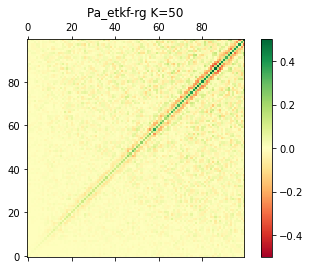

2021-08-31 17:35:09,159 anl INFO model : model
2021-08-31 17:35:09,160 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:09,161 anl INFO linf=False iloc=0 ltlm=False
2021-08-31 17:35:09,227 anl INFO set R
2021-08-31 17:35:09,288 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:09,509 anl INFO save_dh=False cycle0
2021-08-31 17:35:09,511 anl INFO ==K-localization==, lsig=3.0
2021-08-31 17:35:09,790 anl INFO converge gmat, iter_num=3, norm=4.595788570545158e-07
2021-08-31 17:35:09,792 anl INFO err=0.34464725204514485
2021-08-31 17:35:09,793 anl INFO dof=0.5977779276659755


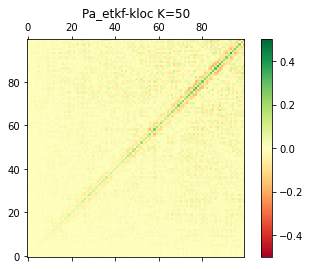

2021-08-31 17:35:09,989 anl INFO model : model
2021-08-31 17:35:09,990 anl INFO pt=po op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:09,990 anl INFO linf=False iloc=None ltlm=False
2021-08-31 17:35:10,048 anl INFO set R
2021-08-31 17:35:10,109 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:10,302 anl INFO save_dh=False cycle0
2021-08-31 17:35:10,494 anl INFO converge gmat, iter_num=3, norm=4.595788570545217e-07
2021-08-31 17:35:10,496 anl INFO err=0.3446472520451578
2021-08-31 17:35:10,497 anl INFO dof=0.5977779276659755


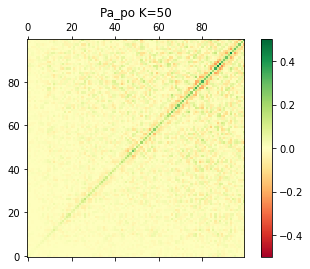

2021-08-31 17:35:10,673 anl INFO model : model
2021-08-31 17:35:10,674 anl INFO pt=po op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:10,674 anl INFO linf=False iloc=2 ltlm=False
2021-08-31 17:35:10,735 anl INFO set R
2021-08-31 17:35:10,791 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:10,791 anl INFO ==B-localization==, lsig=3.0
2021-08-31 17:35:10,792 anl INFO == modulated ensemble, nmode=11 ==
2021-08-31 17:35:10,797 anl INFO dxf.shape=(100, 550)
2021-08-31 17:35:11,096 anl INFO save_dh=False cycle0
2021-08-31 17:35:11,342 anl INFO converge gmat, iter_num=2, norm=1.350379792782122e-06
2021-08-31 17:35:11,349 anl INFO err=1.5049733877000189
2021-08-31 17:35:11,367 anl INFO dof=0.727558125610167


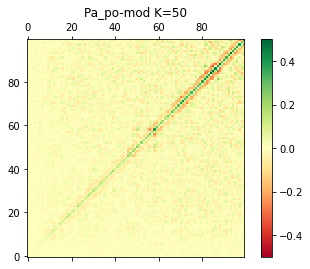

2021-08-31 17:35:11,542 anl INFO model : model
2021-08-31 17:35:11,542 anl INFO pt=po op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:11,543 anl INFO linf=False iloc=0 ltlm=False
2021-08-31 17:35:11,609 anl INFO set R
2021-08-31 17:35:11,663 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:11,858 anl INFO save_dh=False cycle0
2021-08-31 17:35:11,860 anl INFO ==K-localization== lsig=3.0
2021-08-31 17:35:12,136 anl INFO converge gmat, iter_num=3, norm=4.5957885705450003e-07
2021-08-31 17:35:12,137 anl INFO err=0.3446472520450623
2021-08-31 17:35:12,139 anl INFO dof=0.5977779276659755


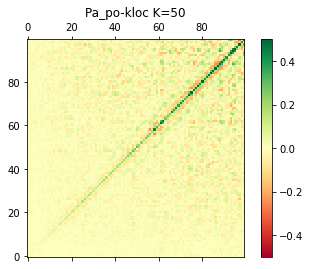

2021-08-31 17:35:12,327 anl INFO model : model
2021-08-31 17:35:12,327 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:12,328 anl INFO linf=False iloc=None ltlm=False
2021-08-31 17:35:12,386 anl INFO set R
2021-08-31 17:35:12,441 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:12,625 anl INFO save_dh=False cycle0
2021-08-31 17:35:13,079 anl INFO converge gmat, iter_num=3, norm=4.595788570545003e-07
2021-08-31 17:35:13,080 anl INFO err=0.3446472520450603
2021-08-31 17:35:13,082 anl INFO dof=0.5977779276659755


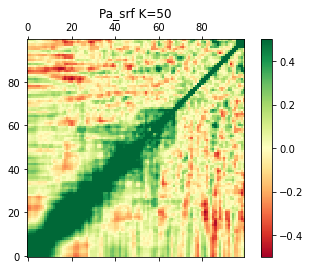

2021-08-31 17:35:13,281 anl INFO model : model
2021-08-31 17:35:13,281 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:13,281 anl INFO linf=False iloc=2 ltlm=False
2021-08-31 17:35:13,339 anl INFO set R
2021-08-31 17:35:13,399 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:13,399 anl INFO ==B-localization==, lsig=3.0
2021-08-31 17:35:13,400 anl INFO == modulated ensemble, nmode=11 ==
2021-08-31 17:35:13,404 anl INFO dxf.shape=(100, 550)
2021-08-31 17:35:13,700 anl INFO save_dh=False cycle0
2021-08-31 17:35:14,016 anl INFO random sampling
2021-08-31 17:35:14,024 anl INFO standard deviation ratio = 0.9926590072353982
2021-08-31 17:35:14,238 anl INFO converge gmat, iter_num=2, norm=1.3503797927821619e-06
2021-08-31 17:35:14,245 anl INFO err=1.5049733877000873
2021-08-31 17:35:14,262 anl INFO dof=0.727558125610167


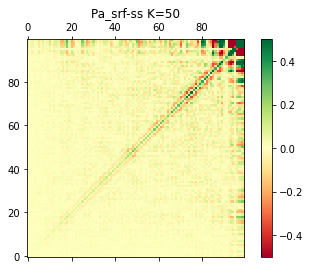

2021-08-31 17:35:14,444 anl INFO model : model
2021-08-31 17:35:14,445 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:14,445 anl INFO linf=False iloc=2 ltlm=False
2021-08-31 17:35:14,506 anl INFO set R
2021-08-31 17:35:14,562 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:14,562 anl INFO ==B-localization==, lsig=3.0
2021-08-31 17:35:14,563 anl INFO == modulated ensemble, nmode=11 ==
2021-08-31 17:35:14,567 anl INFO dxf.shape=(100, 550)
2021-08-31 17:35:14,885 anl INFO save_dh=False cycle0
2021-08-31 17:35:15,597 anl INFO converge gmat, iter_num=2, norm=1.3503797927821619e-06
2021-08-31 17:35:15,605 anl INFO err=1.5049733877000873
2021-08-31 17:35:15,639 anl INFO dof=0.727558125610167


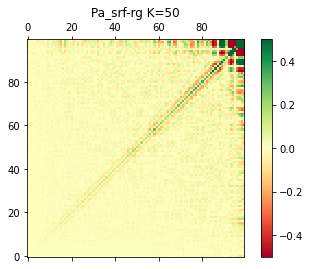

2021-08-31 17:35:15,852 anl INFO model : model
2021-08-31 17:35:15,853 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:15,853 anl INFO linf=False iloc=0 ltlm=False
2021-08-31 17:35:15,913 anl INFO set R
2021-08-31 17:35:15,974 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:16,191 anl INFO save_dh=False cycle0
2021-08-31 17:35:16,192 anl INFO ==K-localization== lsig=3.0
2021-08-31 17:35:16,789 anl INFO converge gmat, iter_num=3, norm=4.595788598713427e-07
2021-08-31 17:35:16,791 anl INFO err=0.34464725209419783
2021-08-31 17:35:16,794 anl INFO dof=0.5977779276659755


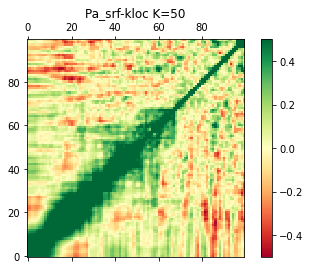

2021-08-31 17:35:17,059 anl INFO model : model
2021-08-31 17:35:17,060 anl INFO pt=letkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:17,060 anl INFO linf=False iloc=0 ltlm=False
2021-08-31 17:35:17,124 anl INFO set R
2021-08-31 17:35:17,180 anl INFO pf max=1.6212950194041214 min=-0.5401768620680059
2021-08-31 17:35:17,403 anl INFO save_dh=False cycle0
2021-08-31 17:35:17,405 anl INFO number of assimilated obs.=100
2021-08-31 17:35:17,406 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,411 anl INFO number of assimilated obs.=75
2021-08-31 17:35:17,412 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,417 anl INFO number of assimilated obs.=61
2021-08-31 17:35:17,418 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,422 anl INFO number of assimilated obs.=55
2021-08-31 17:35:17,423 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,428 anl INFO number of assimilated obs.=52
2021-08-31 17:35:17,430 anl INFO ==R-localization==, lsig=3.0
2021-0

2021-08-31 17:35:17,753 anl INFO number of assimilated obs.=35
2021-08-31 17:35:17,754 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,758 anl INFO number of assimilated obs.=35
2021-08-31 17:35:17,759 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,764 anl INFO number of assimilated obs.=35
2021-08-31 17:35:17,766 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,770 anl INFO number of assimilated obs.=34
2021-08-31 17:35:17,771 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,775 anl INFO number of assimilated obs.=34
2021-08-31 17:35:17,776 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,781 anl INFO number of assimilated obs.=34
2021-08-31 17:35:17,782 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,787 anl INFO number of assimilated obs.=32
2021-08-31 17:35:17,788 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:17,792 anl INFO number of assimilated obs.=32
2021-08-31 17:35:17,794 anl INFO ==R-localization==, lsig=3.0


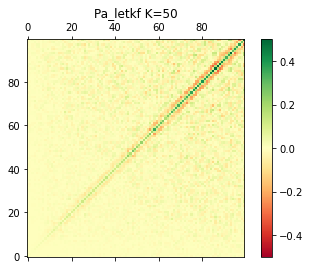

In [169]:
params = {'etkf':('etkf',None,False,False),'etkf-ss':('etkf',2,True,False),'etkf-rg':('etkf',2,False,True),'etkf-kloc':('etkf',0,False,False),
         'po':('po',None,False,False),'po-mod':('po',2,False,False),'po-kloc':('po',0,False,False),
          'srf':('srf',None,False,False),'srf-ss':('srf',2,True,False),'srf-rg':('srf',2,False,True),'srf-kloc':('srf',0,False,False),
         'letkf':('letkf',0,False,False)}
names = ['mod','etkf','etkf-ss','etkf-rg','etkf-kloc','po','po-mod','po-kloc','srf','srf-ss','srf-rg','srf-kloc','letkf']
#names = ['mod','etkf-kloc','srf-kloc','po-kloc','letkf']
xa_list = []
Pa_app_list = [Pam]
from analysis.enkf import EnKF
for ptype in names[1:]:
    pt, iloc, ss, getkf = params[ptype]
    analysis = EnKF(pt, N, K, obs, iloc=iloc, lsig=3.0, ss=ss, getkf=getkf, l_mat=F, l_sqrt=W, calc_dist=calc_dist, calc_dist1=calc_dist1)
    xb = xf
    pb = Pe
    xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, y[::-1], np.arange(p-1,-1,-1))
    #xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, y, np.arange(p))
    xa_list.append(xa.mean(axis=1))
    Pa_app_list.append(Pa)
    fig, ax = plt.subplots()
    mappable = ax.matshow(Pa, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
    ax.invert_yaxis()
    ax.set_title(f'Pa_{ptype} K={K}')
    fig.colorbar(mappable, ax=ax, orientation='vertical')
    if ntest == 0:
        fig.savefig(f'Pa_{ptype}_{K}.pdf')
    plt.show()

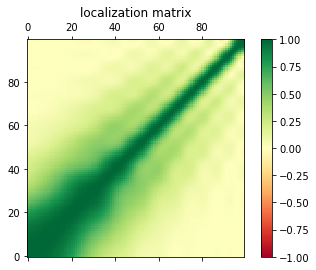

In [170]:
lmat = np.load('model_rho_vint_srf.npy')
fig, ax = plt.subplots()
mappable = ax.matshow(lmat, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax.invert_yaxis()
ax.set_title(f'localization matrix')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'locmat.pdf')
plt.show()

### MLEF

(100, 51)


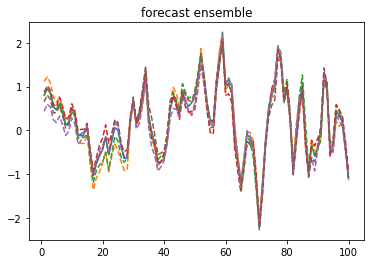

In [171]:
# forecast ensemble
## control
xfc = sPt @ rs.standard_normal(size=N)
## member
xfe = xfc[:, None] + Xf / np.sqrt(K-1)
xf = np.zeros((N,K+1))
xf[:,0] = xfc
xf[:,1:] = xfe
print(xf.shape)
plt.plot(vindex, xf[:,0])
for k in range(1,K+1,10):
    plt.plot(vindex, xf[:,k],linestyle='dashed')
plt.title('forecast ensemble')
plt.show()

2021-08-31 17:35:18,770 anl INFO model : model
2021-08-31 17:35:18,771 anl INFO ndim=100 nmem=50
2021-08-31 17:35:18,772 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:18,772 anl INFO linf=False iloc=None ltlm=False
2021-08-31 17:35:18,773 anl INFO set R
2021-08-31 17:35:19,034 anl INFO save_dh=False
2021-08-31 17:35:19,037 anl INFO eigen value =[-3.45688894e-14  8.58770659e-09  8.87322934e-08  1.54047148e-07
  5.94299183e-07  1.92062200e-06  6.66799856e-06  1.62056478e-05
  2.82474715e-05  5.08502146e-05  6.40686031e-05  1.15242058e-04
  4.69775025e-04  9.25587192e-04  1.50403020e-03  1.93166950e-03
  4.29858791e-03  5.73558492e-03  9.09697203e-03  1.42091339e-02
  5.57620712e-02  6.78883510e-02  1.08709527e-01  2.14934805e-01
  2.96368993e-01  5.40839630e-01  6.53956228e-01  9.70943006e-01
  1.37015100e+00  2.65665687e+00  3.46752184e+00  5.92447943e+00
  7.73314793e+00  1.02196599e+01  1.62930224e+01  1.95511636e+01
  2.31895733e+01  4.17527592e+01  5.317


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.030D+04   GNORM=  1.429D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-08-31 17:35:20,694 anl INFO minimization success
2021-08-31 17:35:20,695 anl INFO iteration = 1
2021-08-31 17:35:20,696 anl INFO final step-length = 1.0000000000000073
2021-08-31 17:35:20,697 anl INFO final function value = 78.97261428360271
2021-08-31 17:35:20,697 anl INFO final gradient norm = 3.200313141163316e-12


   1   6   7.897D+01   3.200D-12   1.0D+00   5.0D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:20,848 anl INFO eigen value =[4.94243821e-14 8.58758132e-09 8.87321727e-08 1.54047192e-07
 5.94299126e-07 1.92062204e-06 6.66799853e-06 1.62056479e-05
 2.82474716e-05 5.08502147e-05 6.40686031e-05 1.15242058e-04
 4.69775025e-04 9.25587192e-04 1.50403020e-03 1.93166950e-03
 4.29858791e-03 5.73558492e-03 9.09697203e-03 1.42091339e-02
 5.57620712e-02 6.78883510e-02 1.08709527e-01 2.14934805e-01
 2.96368993e-01 5.40839630e-01 6.53956228e-01 9.70943006e-01
 1.37015100e+00 2.65665687e+00 3.46752184e+00 5.92447943e+00
 7.73314793e+00 1.02196599e+01 1.62930224e+01 1.95511636e+01
 2.31895733e+01 4.17527592e+01 5.31716514e+01 7.62103461e+01
 8.37856241e+01 1.36672682e+02 1.50121907e+02 2.65719715e+02
 2.92735969e+02 4.86708192e+02 6.98909995e+02 1.59061019e+03
 1.78890631e+03 2.85072347e+03]
2021-08-31 17:35:20,920 anl INFO zmat shape=(100, 50)
2021-08-31 17:35:20,921 anl INFO d shape=(100,)
2021-08-31 17:35:20,923 anl INFO converge gmat, iter_num=3, norm=4.5957885705452137e-07


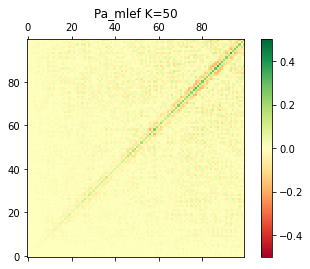

2021-08-31 17:35:21,133 anl INFO model : model
2021-08-31 17:35:21,134 anl INFO ndim=100 nmem=50
2021-08-31 17:35:21,135 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:21,135 anl INFO linf=False iloc=2 ltlm=False
2021-08-31 17:35:21,137 anl INFO set R
2021-08-31 17:35:21,212 anl INFO ==localization==, lsig=3.0
2021-08-31 17:35:21,213 anl INFO == modulated ensemble, nmode=11 ==
2021-08-31 17:35:21,216 anl INFO pf.shape=(100, 550)
2021-08-31 17:35:21,408 anl INFO save_dh=False
2021-08-31 17:35:21,463 anl INFO eigen value =[-5.70381302e-13 -4.01903746e-13 -3.74089521e-13 -2.62356368e-13
 -1.90954734e-13 -1.70160499e-13 -1.64069798e-13 -1.38477904e-13
 -1.23122206e-13 -1.22915855e-13 -1.14288893e-13 -1.11986522e-13
 -1.06894855e-13 -9.57548738e-14 -9.52136691e-14 -9.50665156e-14
 -9.36045604e-14 -8.74341457e-14 -8.10197053e-14 -7.98040220e-14
 -7.93539304e-14 -7.58235430e-14 -7.27228670e-14 -7.25741415e-14
 -6.90213273e-14 -6.58010989e-14 -6.45108134e-14 -5.8764

2021-08-31 17:35:21,468 anl INFO method=CGF
2021-08-31 17:35:21,469 anl INFO cgtype: Fletcher-Reeves
2021-08-31 17:35:21,469 anl INFO restart=False
2021-08-31 17:35:21,470 anl INFO save_hist=False
2021-08-31 17:35:21,685 anl INFO initial function value = 10296.015005682037
2021-08-31 17:35:21,686 anl INFO initial gradient norm = 143.0922739131606



*************************************************
 N=  550

INITIAL VALUES:
 F=  1.030D+04   GNORM=  1.431D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-08-31 17:35:23,249 anl INFO minimization success
2021-08-31 17:35:23,250 anl INFO iteration = 1
2021-08-31 17:35:23,251 anl INFO final step-length = 1.0000000000000009
2021-08-31 17:35:23,251 anl INFO final function value = 58.31557886254068
2021-08-31 17:35:23,252 anl INFO final gradient norm = 4.526430383082262e-12


   1   6   5.832D+01   4.526D-12   1.0D+00   1.0D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:23,480 anl INFO eigen value =[-3.41927599e-13 -3.18519953e-13 -2.88220243e-13 -1.88784608e-13
 -1.82326366e-13 -1.71382520e-13 -1.52516155e-13 -1.40542920e-13
 -1.30993234e-13 -1.18359661e-13 -1.14838527e-13 -1.14456511e-13
 -1.04356997e-13 -1.02430808e-13 -9.17216898e-14 -8.39857265e-14
 -8.25899651e-14 -7.98950207e-14 -7.77101263e-14 -7.76465154e-14
 -7.62392165e-14 -7.49985306e-14 -6.95826169e-14 -6.86306007e-14
 -6.67615770e-14 -6.67247874e-14 -6.23353159e-14 -5.93157652e-14
 -5.90991307e-14 -5.86618062e-14 -5.59205982e-14 -5.48238632e-14
 -5.47614612e-14 -4.98568931e-14 -4.89561827e-14 -4.80077190e-14
 -4.68322892e-14 -4.54460727e-14 -4.38455861e-14 -4.34955044e-14
 -4.25663455e-14 -4.01708189e-14 -3.99384740e-14 -3.88026634e-14
 -3.83916801e-14 -3.81113968e-14 -3.70947503e-14 -3.66901009e-14
 -3.57971953e-14 -3.35521244e-14 -3.34877385e-14 -3.25111147e-14
 -3.23376958e-14 -3.20985353e-14 -3.18950633e-14 -3.08638716e-14
 -3.06974028e-14 -2.98581494e-14 -2.93785321

2021-08-31 17:35:23,556 anl INFO zmat shape=(100, 550)
2021-08-31 17:35:23,557 anl INFO d shape=(100,)
2021-08-31 17:35:23,595 anl INFO converge gmat, iter_num=2, norm=1.3503797927821282e-06
2021-08-31 17:35:23,604 anl INFO err=1.5049733877000364
2021-08-31 17:35:23,622 anl INFO dof=23.583399595660637
2021-08-31 17:35:23,636 anl INFO standard deviation ratio = 0.9971037555220554


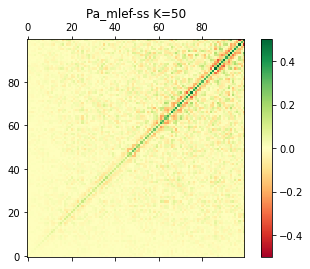

2021-08-31 17:35:23,812 anl INFO model : model
2021-08-31 17:35:23,813 anl INFO ndim=100 nmem=50
2021-08-31 17:35:23,814 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:23,814 anl INFO linf=False iloc=2 ltlm=False
2021-08-31 17:35:23,815 anl INFO set R
2021-08-31 17:35:23,876 anl INFO ==localization==, lsig=3.0
2021-08-31 17:35:23,877 anl INFO == modulated ensemble, nmode=11 ==
2021-08-31 17:35:23,880 anl INFO pf.shape=(100, 550)
2021-08-31 17:35:24,073 anl INFO save_dh=False
2021-08-31 17:35:24,131 anl INFO eigen value =[-5.70381302e-13 -4.01903746e-13 -3.74089521e-13 -2.62356368e-13
 -1.90954734e-13 -1.70160499e-13 -1.64069798e-13 -1.38477904e-13
 -1.23122206e-13 -1.22915855e-13 -1.14288893e-13 -1.11986522e-13
 -1.06894855e-13 -9.57548738e-14 -9.52136691e-14 -9.50665156e-14
 -9.36045604e-14 -8.74341457e-14 -8.10197053e-14 -7.98040220e-14
 -7.93539304e-14 -7.58235430e-14 -7.27228670e-14 -7.25741415e-14
 -6.90213273e-14 -6.58010989e-14 -6.45108134e-14 -5.8764

2021-08-31 17:35:24,136 anl INFO method=CGF
2021-08-31 17:35:24,137 anl INFO cgtype: Fletcher-Reeves
2021-08-31 17:35:24,137 anl INFO restart=False
2021-08-31 17:35:24,138 anl INFO save_hist=False
2021-08-31 17:35:24,347 anl INFO initial function value = 10296.015005682037
2021-08-31 17:35:24,347 anl INFO initial gradient norm = 143.0922739131606



*************************************************
 N=  550

INITIAL VALUES:
 F=  1.030D+04   GNORM=  1.431D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-08-31 17:35:25,947 anl INFO minimization success
2021-08-31 17:35:25,948 anl INFO iteration = 1
2021-08-31 17:35:25,948 anl INFO final step-length = 1.0000000000000009
2021-08-31 17:35:25,949 anl INFO final function value = 58.31557886254068
2021-08-31 17:35:25,950 anl INFO final gradient norm = 4.526430383082262e-12


   1   6   5.832D+01   4.526D-12   1.0D+00   1.0D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:26,180 anl INFO eigen value =[-3.41927599e-13 -3.18519953e-13 -2.88220243e-13 -1.88784608e-13
 -1.82326366e-13 -1.71382520e-13 -1.52516155e-13 -1.40542920e-13
 -1.30993234e-13 -1.18359661e-13 -1.14838527e-13 -1.14456511e-13
 -1.04356997e-13 -1.02430808e-13 -9.17216898e-14 -8.39857265e-14
 -8.25899651e-14 -7.98950207e-14 -7.77101263e-14 -7.76465154e-14
 -7.62392165e-14 -7.49985306e-14 -6.95826169e-14 -6.86306007e-14
 -6.67615770e-14 -6.67247874e-14 -6.23353159e-14 -5.93157652e-14
 -5.90991307e-14 -5.86618062e-14 -5.59205982e-14 -5.48238632e-14
 -5.47614612e-14 -4.98568931e-14 -4.89561827e-14 -4.80077190e-14
 -4.68322892e-14 -4.54460727e-14 -4.38455861e-14 -4.34955044e-14
 -4.25663455e-14 -4.01708189e-14 -3.99384740e-14 -3.88026634e-14
 -3.83916801e-14 -3.81113968e-14 -3.70947503e-14 -3.66901009e-14
 -3.57971953e-14 -3.35521244e-14 -3.34877385e-14 -3.25111147e-14
 -3.23376958e-14 -3.20985353e-14 -3.18950633e-14 -3.08638716e-14
 -3.06974028e-14 -2.98581494e-14 -2.93785321

2021-08-31 17:35:26,253 anl INFO zmat shape=(100, 550)
2021-08-31 17:35:26,254 anl INFO d shape=(100,)
2021-08-31 17:35:26,296 anl INFO converge gmat, iter_num=2, norm=1.3503797927821282e-06
2021-08-31 17:35:26,303 anl INFO err=1.5049733877000364
2021-08-31 17:35:26,323 anl INFO dof=23.583399595660637
2021-08-31 17:35:26,483 anl INFO standard deviation ratio = 1.0500451327480549


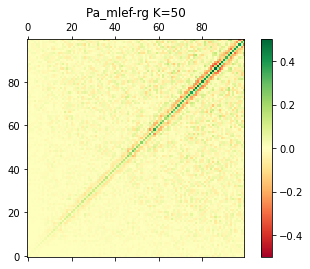

2021-08-31 17:35:26,702 anl INFO model : model
2021-08-31 17:35:26,702 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-08-31 17:35:26,703 anl INFO linf=False ltlm=False
2021-08-31 17:35:26,703 anl INFO set R
2021-08-31 17:35:26,997 anl INFO save_dh=False
2021-08-31 17:35:26,998 anl INFO save_hist=False
2021-08-31 17:35:26,999 anl INFO ==R-localization==, lsig=3.0
2021-08-31 17:35:27,001 anl INFO Number of assimilated obs.=100
2021-08-31 17:35:27,005 anl INFO eigen value =[2.47295518e-14 4.11920485e-09 4.70009470e-08 7.04298147e-08
 3.31416293e-07 1.14563835e-06 3.19437283e-06 7.83961482e-06
 1.50913848e-05 2.10174835e-05 2.67336105e-05 7.69344725e-05
 2.57815282e-04 4.32852274e-04 6.42153013e-04 9.58999536e-04
 2.12355071e-03 2.62337163e-03 4.80129947e-03 9.19974264e-03
 2.24093346e-02 2.98853398e-02 7.78584883e-02 9.31761450e-02
 1.21264318e-01 2.37093694e-01 4.33180076e-01 5.41673453e-01
 6.65406561e-01 1.10044387e+00 1.82020864e+00 2.81806711e+00
 3.33398267e+00 4.740


*************************************************
 N=   50

INITIAL VALUES:
 F=  7.099D+03   GNORM=  1.187D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   5.853D+01   2.962D-12   1.0D+00   6.2D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.460D+03   GNORM=  1.042D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   3.370D+01   2.102D-12   1.0D+00   4.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:27,364 anl INFO eigen value =[-1.91020487e-15  4.42622716e-14  6.11409156e-14  1.44243583e-13
  1.06357450e-12  1.27157426e-11  2.61619088e-11  1.38375729e-10
  1.97935589e-10  4.92884903e-10  3.45515343e-09  9.21921861e-09
  1.50383468e-08  4.19456336e-08  1.23185383e-07  3.25866413e-07
  6.32801826e-07  2.28238388e-06  5.76423198e-06  9.72762498e-06
  3.32089649e-05  5.60868348e-05  8.90020513e-05  2.08971362e-04
  5.12109228e-04  1.16445429e-03  2.05515422e-03  2.91481889e-03
  6.64164125e-03  8.89360414e-03  1.97935276e-02  4.30305379e-02
  7.26428889e-02  9.45659969e-02  1.58035221e-01  2.38862575e-01
  4.51090430e-01  5.07931872e-01  7.23866190e-01  1.44743919e+00
  2.09373535e+00  4.16932276e+00  7.63268361e+00  1.34073127e+01
  2.62408674e+01  4.70264652e+01  9.73939586e+01  3.45205652e+02
  1.32374216e+03  2.11549546e+03]
2021-08-31 17:35:27,367 anl INFO Number of assimilated obs.=61
2021-08-31 17:35:27,371 anl INFO eigen value =[-8.66190185e-14 -3.98170476e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.216D+03   GNORM=  1.018D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.943D+01   1.581D-12   1.0D+00   2.4D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.123D+03   GNORM=  1.010D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.754D+01   1.353D-12   1.0D+00   1.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:27,734 anl INFO eigen value =[-1.21462114e-13 -1.16307189e-13 -9.33066244e-14 -8.06843771e-14
 -5.26569429e-14 -2.05752127e-14 -8.92655093e-15 -1.12035510e-15
  3.41300789e-15  4.02757749e-14  5.78612649e-14  8.67037169e-14
  1.44407535e-13  2.46667123e-13  1.58249614e-12  5.61738202e-12
  3.40033079e-11  1.21682005e-10  5.21519543e-10  1.38811153e-09
  6.53162696e-09  2.12088146e-08  8.28062078e-08  3.12720465e-07
  1.12161905e-06  4.32708124e-06  1.03536655e-05  2.16036122e-05
  8.17191753e-05  1.60490137e-04  4.91706187e-04  1.50601125e-03
  2.79230297e-03  8.15055608e-03  1.14173021e-02  2.26706812e-02
  7.51626991e-02  8.91599324e-02  2.39840765e-01  4.17444234e-01
  9.61989401e-01  1.41138309e+00  2.66644326e+00  8.91024775e+00
  1.42807934e+01  2.40135743e+01  6.73502358e+01  2.48360849e+02
  1.24866677e+03  2.10832826e+03]
2021-08-31 17:35:27,737 anl INFO Number of assimilated obs.=52
2021-08-31 17:35:27,742 anl INFO eigen value =[-1.36925090e-13 -1.22166345e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.099D+03   GNORM=  1.007D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.616D+01   1.643D-12   1.0D+00   2.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.113D+03   GNORM=  1.009D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.539D+01   1.650D-12   1.0D+00   2.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:28,088 anl INFO eigen value =[-1.73134726e-13 -1.18118208e-13 -8.63695169e-14 -6.31808989e-14
 -4.06525281e-14 -3.16734911e-14 -1.42570310e-14 -2.84482485e-15
  2.50145612e-15  2.61818932e-14  5.05127190e-14  6.97249369e-14
  8.46443774e-14  1.00002206e-13  2.29994503e-13  2.36642882e-13
  2.40339463e-13  2.16863008e-12  1.01032207e-11  4.05331268e-11
  2.29849848e-10  9.38587365e-10  4.29262333e-09  1.49846512e-08
  7.00940814e-08  3.77707352e-07  9.60303660e-07  3.97715866e-06
  1.18296949e-05  3.97429121e-05  1.13099412e-04  2.35423502e-04
  8.50973634e-04  2.15727129e-03  6.95198591e-03  8.53218352e-03
  1.77938931e-02  6.23968743e-02  9.96503297e-02  3.46502959e-01
  6.77458038e-01  8.91008764e-01  2.24358634e+00  6.79402587e+00
  1.01911101e+01  2.09346179e+01  5.93438856e+01  2.26683209e+02
  1.25446547e+03  2.14633630e+03]
2021-08-31 17:35:28,091 anl INFO Number of assimilated obs.=49
2021-08-31 17:35:28,096 anl INFO eigen value =[-2.23565301e-13 -1.36652512e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.151D+03   GNORM=  1.013D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.510D+01   1.861D-12   1.0D+00   3.4D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.205D+03   GNORM=  1.018D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.500D+01   1.512D-12   1.0D+00   2.2D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:28,452 anl INFO eigen value =[-1.93209192e-13 -1.36338033e-13 -9.13564599e-14 -6.33072891e-14
 -4.77760819e-14 -3.13066758e-14 -1.47813236e-14  4.39426637e-15
  1.66609688e-14  2.92877689e-14  4.82296409e-14  6.08173329e-14
  7.34303371e-14  8.31785884e-14  1.24650920e-13  1.51202505e-13
  2.75557934e-13  3.08287476e-13  1.52893865e-12  1.07440060e-11
  3.38760220e-11  2.17880350e-10  6.39326025e-10  5.92437902e-09
  2.15073220e-08  1.11299919e-07  3.87186341e-07  1.63509137e-06
  5.62797360e-06  1.37690721e-05  4.18363858e-05  1.42961886e-04
  5.09098239e-04  1.22655269e-03  3.14357332e-03  8.29871752e-03
  9.73770689e-03  4.29103146e-02  8.77665581e-02  2.87854334e-01
  5.34790650e-01  8.45187466e-01  2.02898362e+00  5.75041460e+00
  9.39967792e+00  2.04739396e+01  5.77605285e+01  2.27077662e+02
  1.29063696e+03  2.19454834e+03]
2021-08-31 17:35:28,455 anl INFO Number of assimilated obs.=47
2021-08-31 17:35:28,459 anl INFO eigen value =[-1.88920100e-13 -1.40733349e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.270D+03   GNORM=  1.024D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.505D+01   1.939D-12   1.0D+00   3.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.341D+03   GNORM=  1.031D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.523D+01   1.700D-12   1.0D+00   2.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:28,801 anl INFO eigen value =[-2.58891056e-13 -1.68281208e-13 -1.46124444e-13 -7.09754624e-14
 -5.31760394e-14 -2.76710007e-14 -1.01255180e-14 -7.88158233e-15
  1.78432282e-14  2.41145657e-14  3.72195337e-14  4.26005098e-14
  6.64258275e-14  7.97279546e-14  8.30030295e-14  1.10852338e-13
  1.22946495e-13  1.82243376e-13  6.62636027e-13  4.66503576e-12
  1.78676530e-11  6.39525276e-11  3.59290070e-10  3.77327704e-09
  1.22915825e-08  5.72033953e-08  2.29083732e-07  9.94147389e-07
  2.99282309e-06  9.66234850e-06  3.12381531e-05  1.25418619e-04
  3.67788156e-04  7.47330166e-04  2.49295321e-03  7.43707356e-03
  8.66062681e-03  3.61778672e-02  8.67804211e-02  2.53905767e-01
  5.05932461e-01  8.62377269e-01  1.96787207e+00  5.47283505e+00
  9.58447934e+00  2.11789828e+01  5.94558874e+01  2.39061566e+02
  1.33532448e+03  2.24360608e+03]
2021-08-31 17:35:28,804 anl INFO Number of assimilated obs.=47
2021-08-31 17:35:28,807 anl INFO eigen value =[-3.76468335e-13 -2.15866264e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.416D+03   GNORM=  1.038D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.545D+01   2.124D-12   1.0D+00   4.2D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.492D+03   GNORM=  1.046D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.571D+01   1.699D-12   1.0D+00   2.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:29,107 anl INFO eigen value =[-1.97581944e-13 -1.53062380e-13 -1.15647855e-13 -9.48046212e-14
 -7.27275284e-14 -6.79893697e-14 -3.36129060e-14 -2.97465877e-14
 -1.80913625e-14 -2.80439252e-15  8.14272194e-15  2.39620734e-14
  2.89983399e-14  5.56595342e-14  7.89371094e-14  1.15286266e-13
  1.43844872e-13  2.12834476e-13  6.96828043e-13  5.01979853e-12
  1.82549890e-11  6.49224477e-11  3.69849338e-10  3.87293291e-09
  1.24711853e-08  5.83275970e-08  2.36200114e-07  1.00228091e-06
  3.02917854e-06  9.85366988e-06  3.23934028e-05  1.28470599e-04
  3.68772684e-04  7.47111032e-04  2.54153039e-03  7.52264902e-03
  8.84261062e-03  3.76189303e-02  9.02535517e-02  2.51153143e-01
  5.24775688e-01  9.11269371e-01  2.04346543e+00  5.64344350e+00
  1.02992207e+01  2.26310357e+01  6.32729166e+01  2.59269482e+02
  1.37223374e+03  2.28993915e+03]
2021-08-31 17:35:29,109 anl INFO Number of assimilated obs.=47
2021-08-31 17:35:29,112 anl INFO eigen value =[-1.59400378e-13 -1.37639510e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.566D+03   GNORM=  1.053D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.598D+01   1.750D-12   1.0D+00   2.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.638D+03   GNORM=  1.059D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.627D+01   1.906D-12   1.0D+00   3.2D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:29,424 anl INFO eigen value =[-2.23139222e-13 -1.75824905e-13 -1.21231092e-13 -7.40153505e-14
 -6.02933352e-14 -5.62596773e-14 -3.54098127e-14 -1.79562080e-14
 -3.04638275e-15  1.78860151e-14  2.83553019e-14  3.10163328e-14
  5.54800693e-14  7.24780806e-14  9.95961817e-14  1.19709418e-13
  1.37741356e-13  1.98022696e-13  7.46742475e-13  5.33076570e-12
  1.98171840e-11  7.00615006e-11  3.96196524e-10  4.11132421e-09
  1.32755041e-08  6.21568285e-08  2.55863956e-07  1.05541128e-06
  3.24700741e-06  1.04779856e-05  3.52149164e-05  1.34469593e-04
  3.96958218e-04  8.14244465e-04  2.70707931e-03  8.03990254e-03
  9.15963834e-03  4.22627869e-02  9.55455468e-02  2.63104915e-01
  5.65577498e-01  9.83755948e-01  2.22443200e+00  6.07993397e+00
  1.14478704e+01  2.46045781e+01  6.86414536e+01  2.86397225e+02
  1.38751078e+03  2.33123783e+03]
2021-08-31 17:35:29,427 anl INFO Number of assimilated obs.=47
2021-08-31 17:35:29,430 anl INFO eigen value =[-3.26083284e-13 -1.71363607e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.704D+03   GNORM=  1.066D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.655D+01   2.265D-12   1.0D+00   4.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.763D+03   GNORM=  1.071D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.683D+01   1.741D-12   1.0D+00   2.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:29,772 anl INFO eigen value =[-3.12144998e-13 -1.70636724e-13 -1.17413520e-13 -8.69259447e-14
 -4.50792003e-14 -4.25473303e-14 -1.97047800e-14 -7.61028642e-15
 -2.81827857e-15  1.53703778e-14  2.30719585e-14  3.03559998e-14
  5.52751409e-14  8.96485471e-14  1.19152282e-13  1.33461929e-13
  1.69678582e-13  3.18239565e-13  8.40224845e-13  5.92516730e-12
  2.20694969e-11  7.92428479e-11  4.35346464e-10  4.45247719e-09
  1.46156496e-08  6.85180337e-08  2.86300965e-07  1.14264619e-06
  3.63474298e-06  1.14667965e-05  3.96861242e-05  1.41425583e-04
  4.53177937e-04  9.48861281e-04  2.95961763e-03  8.50377907e-03
  1.01044933e-02  5.02381961e-02  1.00863395e-01  2.88265226e-01
  6.23389905e-01  1.07896729e+00  2.48585618e+00  6.74455876e+00
  1.30256061e+01  2.69261671e+01  7.51869365e+01  3.19843462e+02
  1.37110575e+03  2.36327628e+03]
2021-08-31 17:35:29,774 anl INFO Number of assimilated obs.=47
2021-08-31 17:35:29,779 anl INFO eigen value =[-4.78161138e-13 -2.35691890e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.813D+03   GNORM=  1.076D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.710D+01   1.964D-12   1.0D+00   3.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.850D+03   GNORM=  1.079D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.735D+01   2.322D-12   1.0D+00   4.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:30,168 anl INFO eigen value =[-2.26043258e-13 -1.57317719e-13 -8.97397120e-14 -7.14555377e-14
 -4.57685510e-14 -4.15339773e-14 -2.59523505e-14 -1.02596190e-14
  9.39768906e-16  1.16814942e-14  2.11138170e-14  3.07637904e-14
  4.53270515e-14  6.69382459e-14  8.86529675e-14  1.33272288e-13
  1.74299268e-13  2.20425801e-13  8.69520116e-13  6.38260765e-12
  2.47083939e-11  9.35027101e-11  4.85239101e-10  4.85942678e-09
  1.63839506e-08  7.76607466e-08  3.25427314e-07  1.25363322e-06
  4.20267654e-06  1.27733286e-05  4.59691730e-05  1.47318759e-04
  5.40153497e-04  1.16560616e-03  3.26467559e-03  8.65449733e-03
  1.20694406e-02  6.21584031e-02  1.04135114e-01  3.25195759e-01
  6.93461901e-01  1.20585835e+00  2.78232089e+00  7.65007185e+00
  1.50460571e+01  2.94541523e+01  8.25473205e+01  3.59147230e+02
  1.31877825e+03  2.37804527e+03]
2021-08-31 17:35:30,171 anl INFO Number of assimilated obs.=48
2021-08-31 17:35:30,175 anl INFO eigen value =[-1.86042959e-13 -1.67647577e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.873D+03   GNORM=  1.081D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.764D+01   2.080D-12   1.0D+00   3.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.879D+03   GNORM=  1.082D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.785D+01   1.604D-12   1.0D+00   2.2D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:30,495 anl INFO eigen value =[-1.99893913e-13 -1.23451860e-13 -8.68794474e-14 -5.00060275e-14
 -3.77177914e-14 -2.29856156e-14 -5.04336203e-15 -1.33486824e-15
  1.04225869e-14  2.16656990e-14  3.64871945e-14  4.50550350e-14
  6.03588385e-14  8.67545727e-14  1.22967861e-13  1.69405853e-13
  3.90215511e-13  4.38945711e-13  1.93772994e-12  1.62541230e-11
  4.87734977e-11  3.60294556e-10  9.46891800e-10  7.90309990e-09
  2.88519981e-08  1.77054563e-07  5.63135358e-07  2.10962698e-06
  8.27782587e-06  2.06132843e-05  7.03417483e-05  1.64009027e-04
  8.54905335e-04  1.98261927e-03  4.36491386e-03  8.73243879e-03
  1.73491184e-02  8.50382343e-02  1.04080166e-01  3.77611062e-01
  7.86246926e-01  1.39965737e+00  3.04459279e+00  8.87216998e+00
  1.75204558e+01  3.21517404e+01  9.02694973e+01  4.03637117e+02
  1.23236205e+03  2.36461152e+03]
2021-08-31 17:35:30,498 anl INFO Number of assimilated obs.=49
2021-08-31 17:35:30,501 anl INFO eigen value =[-3.15268672e-13 -1.90308497e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.865D+03   GNORM=  1.080D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.811D+01   2.045D-12   1.0D+00   3.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:30,707 anl INFO cgtype: Fletcher-Reeves
2021-08-31 17:35:30,708 anl INFO restart=False
2021-08-31 17:35:30,709 anl INFO initial function value = 5826.850420396232
2021-08-31 17:35:30,710 anl INFO initial gradient norm = 107.6900293097855
2021-08-31 17:35:30,719 anl INFO minimization success
2021-08-31 17:35:30,722 anl INFO iteration = 1
2021-08-31 17:35:30,722 anl INFO final step-length = 1.0
2021-08-31 17:35:30,723 anl INFO final function value = 28.2792140249872
2021-08-31 17:35:30,724 anl INFO final gradient norm = 2.016998563748844e-12
2021-08-31 17:35:30,894 anl INFO eigen value =[-1.10700400e-13 -9.75718753e-14 -4.91639687e-14 -3.29202464e-14
 -1.44744690e-14 -9.50348803e-15  3.50323540e-15  1.53974578e-14
  1.67229783e-14  3.93837854e-14  5.64627932e-14  8.13319335e-14
  9.72166405e-14  1.16846563e-13  1.37415070e-13  1.96985510e-13
  6.98391202e-13  1.61069779e-12  4.74671879e-12  3.22551020e-11
  1.39949285e-10  7.31110769e-10  2.87469743e-09  1.33666974e-08
 


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.827D+03   GNORM=  1.077D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.828D+01   2.017D-12   1.0D+00   3.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.763D+03   GNORM=  1.071D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-08-31 17:35:30,918 anl INFO minimization success
2021-08-31 17:35:30,920 anl INFO iteration = 1
2021-08-31 17:35:30,921 anl INFO final step-length = 0.999999999999999
2021-08-31 17:35:30,922 anl INFO final function value = 28.4198886801081
2021-08-31 17:35:30,923 anl INFO final gradient norm = 1.5190792685992508e-12
2021-08-31 17:35:31,075 anl INFO eigen value =[-1.32175113e-13 -9.80365597e-14 -8.41875056e-14 -6.54451750e-14
 -4.46476223e-14 -3.65236266e-14 -8.18163112e-15  3.90140974e-15
  1.45187560e-14  2.22824409e-14  5.35214497e-14  7.68027900e-14
  8.63973465e-14  1.27926285e-13  1.87606008e-13  2.20513318e-13
  1.00193470e-12  1.64222455e-12  5.17419176e-12  3.33046207e-11
  1.55728199e-10  7.76687996e-10  3.20020031e-09  1.39869559e-08
  5.21767838e-08  3.61703586e-07  9.40226790e-07  3.73629372e-06
  1.37498235e-05  4.85961167e-05  1.14849703e-04  2.04145881e-04
  1.37103881e-03  2.77233052e-03  8.01689134e-03  9.22364922e-03
  2.90487040e-02  9.69172334e-02  1.33348701e-

   1   6   2.842D+01   1.519D-12   1.0D+00   2.0D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.670D+03   GNORM=  1.062D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.866D+01   2.612D-12   1.0D+00   6.0D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:31,240 anl INFO eigen value =[-1.76493445e-13 -1.18146911e-13 -7.54975691e-14 -4.82766150e-14
 -3.49070863e-14 -2.22485922e-14 -1.11072894e-14  1.30840783e-14
  1.99783594e-14  3.38385499e-14  4.92032458e-14  5.00205432e-14
  7.15044771e-14  9.27562025e-14  1.07492113e-13  1.67925461e-13
  4.45477254e-13  2.56828784e-12  1.73672360e-11  6.16140480e-11
  3.95753203e-10  1.48153555e-09  7.81408246e-09  1.98020011e-08
  1.00467165e-07  5.86096985e-07  1.37455801e-06  6.07423903e-06
  1.76559695e-05  7.63759888e-05  1.45517679e-04  3.33499698e-04
  1.78002317e-03  2.93417019e-03  8.62912055e-03  1.33079715e-02
  3.72712129e-02  9.41106158e-02  1.58289402e-01  4.40639282e-01
  9.46978060e-01  2.20914244e+00  3.24481447e+00  1.15620999e+01
  2.30981848e+01  3.96361440e+01  1.04094597e+02  5.01802637e+02
  9.85858806e+02  2.21422378e+03]
2021-08-31 17:35:31,243 anl INFO Number of assimilated obs.=50
2021-08-31 17:35:31,247 anl INFO eigen value =[-9.60234450e-14 -8.99022356e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.546D+03   GNORM=  1.050D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.878D+01   2.591D-12   1.0D+00   6.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  5.389D+03   GNORM=  1.035D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.903D+01   1.577D-12   1.0D+00   2.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:31,578 anl INFO eigen value =[-1.36817633e-13 -8.69946920e-14 -6.15365480e-14 -4.99789833e-14
 -2.83910981e-14 -1.36167812e-14  3.27838145e-15  1.32687826e-14
  3.78770911e-14  4.72372011e-14  5.46845412e-14  6.78426023e-14
  9.44893209e-14  1.43631539e-13  1.47369485e-13  2.50715149e-13
  1.47580601e-12  8.08644801e-12  3.32978911e-11  1.80467842e-10
  7.02903782e-10  3.47704970e-09  1.62113136e-08  3.52177969e-08
  1.75075340e-07  9.06288082e-07  2.33585778e-06  1.09489306e-05
  2.59007505e-05  9.54731747e-05  1.79925007e-04  7.30368147e-04
  2.49924856e-03  3.24271014e-03  8.71833702e-03  2.16672545e-02
  5.50985753e-02  9.07968312e-02  2.13514420e-01  4.35067272e-01
  9.95075622e-01  2.86193283e+00  3.28771868e+00  1.23209523e+01
  2.51517982e+01  4.65191428e+01  1.08632824e+02  5.47751683e+02
  8.46581883e+02  2.07048271e+03]
2021-08-31 17:35:31,581 anl INFO Number of assimilated obs.=51
2021-08-31 17:35:31,585 anl INFO eigen value =[-1.85804023e-13 -8.36700653e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.198D+03   GNORM=  1.017D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.916D+01   2.450D-12   1.0D+00   5.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  4.974D+03   GNORM=  9.945D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.943D+01   1.396D-12   1.0D+00   2.0D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:31,930 anl INFO eigen value =[-9.55882752e-14 -8.52825834e-14 -5.79698059e-14 -3.74199098e-14
 -2.59522757e-14 -1.40853455e-14  3.30365564e-15  9.88944729e-15
  1.46188918e-14  3.87697534e-14  5.35730616e-14  7.75791262e-14
  9.38859127e-14  1.06678209e-13  1.64041493e-13  4.88973764e-13
  2.20871476e-12  2.10467845e-11  7.94140309e-11  4.73732098e-10
  1.52908671e-09  7.66568645e-09  2.07639093e-08  9.02064138e-08
  2.94078017e-07  1.20577092e-06  3.78673971e-06  1.69350913e-05
  5.08703784e-05  1.01706982e-04  2.32810638e-04  1.30750961e-03
  2.65711588e-03  5.15817462e-03  9.21606868e-03  3.01911229e-02
  6.32244538e-02  1.16388127e-01  2.85502874e-01  4.06944479e-01
  1.00408183e+00  2.96071663e+00  4.16450578e+00  1.22430902e+01
  2.61478460e+01  5.64260079e+01  1.11119792e+02  5.74366708e+02
  7.19756932e+02  1.88965105e+03]
2021-08-31 17:35:31,933 anl INFO Number of assimilated obs.=53
2021-08-31 17:35:31,937 anl INFO eigen value =[-1.71456493e-13 -7.83520777e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  4.718D+03   GNORM=  9.683D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   6   2.974D+01   1.534D-12   1.0D+00   2.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  4.432D+03   GNORM=  9.383D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   6.896D+01   8.834D+00   9.1D-01   8.9D-03
   2   7   2.995D+01   2.918D-13   9.1D-01   1.1D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:32,269 anl INFO eigen value =[-9.28404257e-14 -7.04906084e-14 -5.82904411e-14 -4.62812845e-14
 -1.96013909e-14 -1.30925771e-14 -4.61107755e-15  5.21252913e-16
  1.24985048e-14  1.67658310e-14  3.19772923e-14  5.04634040e-14
  7.39861548e-14  8.10989701e-14  4.04927861e-13  1.30089857e-12
  6.97099420e-12  3.36756223e-11  2.12747966e-10  7.51137765e-10
  3.54852366e-09  1.75979586e-08  3.48824920e-08  1.38987804e-07
  6.24059145e-07  1.83162082e-06  5.46770434e-06  2.18810580e-05
  7.65573951e-05  1.45613557e-04  3.30311455e-04  1.65759314e-03
  2.83582873e-03  7.12193231e-03  1.35671868e-02  3.57420230e-02
  5.94294544e-02  1.80199933e-01  3.51933329e-01  4.02031416e-01
  9.52040649e-01  2.88961054e+00  5.56388444e+00  1.13528949e+01
  2.62731874e+01  6.73196042e+01  1.13355562e+02  5.24207118e+02
  6.62290961e+02  1.68932648e+03]
2021-08-31 17:35:32,271 anl INFO Number of assimilated obs.=54
2021-08-31 17:35:32,276 anl INFO eigen value =[-7.47172053e-14 -5.77630597e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  4.122D+03   GNORM=  9.047D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   4.515D+01   5.467D+00   9.4D-01   3.7D-03
   2   7   3.021D+01   1.928D-13   9.4D-01   1.2D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  3.793D+03   GNORM=  8.675D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.192D+01   1.753D+00   9.8D-01   4.1D-04
   2   7   3.038D+01   2.735D-13   9.8D-01   2.4D-26

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:32,578 anl INFO eigen value =[-7.20665888e-14 -5.55175331e-14 -4.64599202e-14 -1.63734954e-14
 -8.97687620e-15 -1.95946448e-15  1.28241185e-14  2.00380955e-14
  4.27426188e-14  5.30687498e-14  6.02733826e-14  7.96518466e-14
  1.03469346e-13  1.81550147e-13  8.21072341e-13  2.63372270e-12
  1.87947652e-11  8.99216181e-11  4.26362766e-10  1.42248944e-09
  5.05435944e-09  2.36920091e-08  9.39091991e-08  2.25274531e-07
  8.17211258e-07  3.60145175e-06  1.04865682e-05  2.56445246e-05
  7.75494690e-05  2.19906883e-04  5.86239289e-04  1.61770295e-03
  3.41806653e-03  7.59301628e-03  2.38620721e-02  3.76601235e-02
  5.96084696e-02  2.35249224e-01  3.35281733e-01  5.69749716e-01
  8.34036979e-01  2.87683872e+00  7.05550451e+00  1.00637345e+01
  2.59467609e+01  7.26190302e+01  1.21238050e+02  4.19405265e+02
  6.46386791e+02  1.49459715e+03]
2021-08-31 17:35:32,581 anl INFO Number of assimilated obs.=55
2021-08-31 17:35:32,584 anl INFO eigen value =[-9.35585835e-14 -5.85764258e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.453D+03   GNORM=  8.273D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.053D+01   1.227D-12   1.0D+00   2.2D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  3.108D+03   GNORM=  7.846D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.057D+01   6.765D-12   1.0D+00   7.4D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:32,886 anl INFO eigen value =[-6.14212357e-14 -3.38171155e-14 -2.53358808e-14 -1.11822151e-14
 -7.43646799e-15 -1.68114918e-15  1.04755474e-14  2.08523866e-14
  3.27200101e-14  4.73047960e-14  1.07397611e-13  2.74531152e-13
  3.87521142e-13  5.85691171e-13  2.88701985e-12  1.93324619e-11
  1.01918344e-10  4.23501063e-10  1.70089359e-09  5.37159013e-09
  1.31688015e-08  5.77648703e-08  1.23179517e-07  7.20958289e-07
  1.69592829e-06  6.52498840e-06  2.24866657e-05  5.99071965e-05
  1.25216364e-04  3.11360332e-04  9.84907113e-04  1.79752709e-03
  5.28976684e-03  9.03908137e-03  2.49424088e-02  4.58628847e-02
  8.69569590e-02  2.14773192e-01  3.69503504e-01  6.71817245e-01
  9.13555573e-01  2.88821849e+00  7.29250001e+00  9.80648281e+00
  2.57564339e+01  6.78859708e+01  1.37494468e+02  3.21772736e+02
  6.03344341e+02  1.33170119e+03]
2021-08-31 17:35:32,888 anl INFO Number of assimilated obs.=56
2021-08-31 17:35:32,892 anl INFO eigen value =[-6.37559361e-14 -4.96043580e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  2.768D+03   GNORM=  7.399D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.047D+01   7.470D-13   1.0D+00   1.0D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  2.441D+03   GNORM=  6.943D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.024D+01   4.696D-12   1.0D+00   4.6D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:33,206 anl INFO eigen value =[-9.97406405e-14 -6.75274155e-14 -2.75647764e-14 -2.33396578e-14
 -1.05169307e-14 -4.04097340e-15  9.47302887e-15  2.58949045e-14
  3.16427366e-14  3.65687907e-14  7.30108074e-14  8.34078102e-14
  4.34460959e-13  9.56675126e-13  8.20231152e-12  4.28863668e-11
  2.14531560e-10  6.80766221e-10  3.12019275e-09  7.67600573e-09
  3.69632305e-08  7.19972771e-08  2.68125951e-07  6.22862675e-07
  3.08587150e-06  1.18721592e-05  2.00018529e-05  7.29171347e-05
  2.06038260e-04  5.26201858e-04  8.62132950e-04  1.84574198e-03
  6.49243298e-03  1.42427627e-02  1.95524320e-02  4.38506379e-02
  1.34926658e-01  1.86729981e-01  3.60462472e-01  5.74512974e-01
  1.39522316e+00  2.76155989e+00  6.04316823e+00  1.07987086e+01
  2.62234035e+01  5.71806417e+01  1.54169432e+02  2.41725517e+02
  5.27369500e+02  1.21346888e+03]
2021-08-31 17:35:33,209 anl INFO Number of assimilated obs.=58
2021-08-31 17:35:33,212 anl INFO eigen value =[-4.89351134e-14 -3.38445758e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  2.134D+03   GNORM=  6.487D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.986D+01   6.852D-12   1.0D+00   1.1D-26

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.855D+03   GNORM=  6.042D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.935D+01   2.053D-12   1.0D+00   1.2D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:33,498 anl INFO eigen value =[-5.91798899e-14 -5.49401270e-14 -2.95140487e-14 -2.36186211e-14
 -7.21477958e-15  7.64767873e-16  6.02415495e-15  1.81118741e-14
  2.07971208e-14  4.28327834e-14  5.68041931e-14  2.61219239e-13
  5.18112474e-13  2.00160254e-12  1.16527695e-11  9.37344793e-11
  3.55662981e-10  1.22675125e-09  4.50897320e-09  1.54468424e-08
  4.85005407e-08  1.12584786e-07  4.52401419e-07  8.68231486e-07
  3.73995799e-06  1.55806687e-05  2.94085167e-05  9.61756404e-05
  2.39829003e-04  6.26711286e-04  1.10506879e-03  1.80443002e-03
  6.77506445e-03  1.45467329e-02  2.53595600e-02  4.23425730e-02
  1.18198780e-01  2.40771712e-01  2.78088671e-01  6.20045776e-01
  1.79858328e+00  2.54691327e+00  4.83627178e+00  1.18462986e+01
  2.69254266e+01  4.51459022e+01  1.60522631e+02  1.79517929e+02
  4.40824263e+02  1.13145936e+03]
2021-08-31 17:35:33,501 anl INFO Number of assimilated obs.=59
2021-08-31 17:35:33,504 anl INFO eigen value =[-6.35186413e-14 -5.11669336e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.610D+03   GNORM=  5.623D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.874D+01   1.053D-12   1.0D+00   3.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.403D+03   GNORM=  5.245D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.805D+01   2.065D-12   1.0D+00   1.6D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:33,792 anl INFO eigen value =[-5.02778683e-14 -2.71367142e-14 -1.14283356e-14 -2.04452674e-15
  6.09848220e-15  1.40294021e-14  2.65127538e-14  3.47753402e-14
  4.64849256e-14  6.40022589e-14  2.01075510e-13  5.39819692e-13
  3.04487591e-12  1.17332906e-11  6.81952946e-11  3.54762971e-10
  7.49144462e-10  1.48197247e-09  1.07449477e-08  3.56035116e-08
  1.01739135e-07  2.41334537e-07  7.88511511e-07  2.07733283e-06
  5.57619995e-06  1.73857390e-05  6.83835011e-05  1.51636759e-04
  3.40607081e-04  7.00038036e-04  1.41560183e-03  3.15088013e-03
  6.41303360e-03  1.12770720e-02  2.91840624e-02  6.22373227e-02
  1.00761508e-01  1.78186767e-01  3.00978505e-01  8.54983980e-01
  1.44080742e+00  2.72622013e+00  3.99683343e+00  1.30208037e+01
  2.51019420e+01  3.70053492e+01  1.31379042e+02  1.49863117e+02
  3.67666186e+02  1.07084701e+03]
2021-08-31 17:35:33,794 anl INFO Number of assimilated obs.=60
2021-08-31 17:35:33,797 anl INFO eigen value =[-7.11684801e-14 -6.02328943e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.238D+03   GNORM=  4.921D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.733D+01   9.492D-13   1.0D+00   3.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.116D+03   GNORM=  4.669D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.659D+01   4.174D-13   1.0D+00   8.0D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:34,086 anl INFO eigen value =[-5.32281337e-14 -1.94251626e-14 -1.49636819e-14 -8.23710108e-15
  1.26464918e-15  1.77323516e-14  2.12102064e-14  4.71407131e-14
  6.24229482e-14  1.35880330e-13  3.41111949e-13  1.17011977e-12
  5.07129713e-12  3.46987827e-11  7.69487303e-11  4.21052502e-10
  1.06961972e-09  6.38480734e-09  1.27818517e-08  2.58993725e-08
  1.59630228e-07  2.40612154e-07  1.25986149e-06  2.51671893e-06
  6.48628228e-06  2.27682807e-05  8.75473741e-05  1.58044735e-04
  2.80898616e-04  6.66199942e-04  2.15337528e-03  3.84683829e-03
  6.41433284e-03  9.01915788e-03  2.65984826e-02  5.74886474e-02
  8.79373140e-02  1.64961032e-01  3.20676663e-01  9.06989698e-01
  1.17205806e+00  2.39735916e+00  3.96645558e+00  1.24992891e+01
  2.02677716e+01  3.61766057e+01  9.42153266e+01  1.27561856e+02
  3.09534218e+02  1.02261971e+03]
2021-08-31 17:35:34,088 anl INFO Number of assimilated obs.=62
2021-08-31 17:35:34,091 anl INFO eigen value =[-5.01085440e-14 -2.29575744e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.038D+03   GNORM=  4.499D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.590D+01   4.183D-13   1.0D+00   8.6D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.001D+03   GNORM=  4.418D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.525D+01   4.282D-13   1.0D+00   9.4D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:34,379 anl INFO eigen value =[-2.68461448e-14 -5.83070864e-15  3.87070202e-15  1.15914039e-14
  2.07400567e-14  3.05594237e-14  5.22266017e-14  5.27871147e-14
  9.31917818e-14  1.99851594e-13  1.52961887e-12  3.11188554e-12
  3.68753734e-11  6.98186712e-11  2.96603720e-10  7.16888979e-10
  3.96324689e-09  6.26959042e-09  1.86028582e-08  8.61035310e-08
  2.74316287e-07  5.45515913e-07  1.81713658e-06  3.56451976e-06
  9.33392953e-06  4.02695984e-05  1.00565371e-04  1.37165523e-04
  3.80769252e-04  8.37311627e-04  2.31718374e-03  3.65466934e-03
  5.46881784e-03  1.42174319e-02  2.53065726e-02  4.94353513e-02
  6.10499145e-02  1.78510806e-01  3.98905420e-01  5.28404825e-01
  1.16090228e+00  2.27514165e+00  4.12518481e+00  8.77152513e+00
  1.75885723e+01  3.66163780e+01  7.05357222e+01  1.05702576e+02
  2.54288266e+02  9.80133638e+02]
2021-08-31 17:35:34,382 anl INFO Number of assimilated obs.=63
2021-08-31 17:35:34,385 anl INFO eigen value =[-5.16301414e-14 -2.94194747e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.003D+03   GNORM=  4.424D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.463D+01   4.843D-13   1.0D+00   1.2D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.041D+03   GNORM=  4.509D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.412D+01   3.844D-13   1.0D+00   7.3D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:34,678 anl INFO eigen value =[-4.70316973e-14 -3.28232850e-14 -1.34477481e-14  3.51646195e-15
  7.91343495e-15  1.83278148e-14  2.83137874e-14  3.57178419e-14
  8.79610460e-14  2.34012809e-13  1.94730565e-12  7.27779088e-12
  3.27831491e-11  1.74480210e-10  2.42384773e-10  1.52809358e-09
  3.56398725e-09  1.10220746e-08  3.16888749e-08  5.56525820e-08
  2.88983290e-07  6.80806163e-07  2.47616992e-06  4.63897954e-06
  1.34082156e-05  4.37629655e-05  6.55578348e-05  1.25230829e-04
  3.46857328e-04  9.31807610e-04  1.95624849e-03  3.05211335e-03
  4.58889290e-03  1.34535815e-02  2.34386559e-02  3.21470414e-02
  7.43703916e-02  1.64566534e-01  2.86525831e-01  4.10766198e-01
  1.10747649e+00  2.23518842e+00  3.45562166e+00  6.52156714e+00
  1.42118932e+01  2.98056380e+01  6.92342420e+01  8.83552588e+01
  1.98542626e+02  9.34389142e+02]
2021-08-31 17:35:34,680 anl INFO Number of assimilated obs.=65
2021-08-31 17:35:34,684 anl INFO eigen value =[-2.25231967e-14 -1.64397212e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.107D+03   GNORM=  4.655D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.372D+01   4.325D-13   1.0D+00   8.6D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.195D+03   GNORM=  4.840D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.316D+01   6.260D-13   1.0D+00   1.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:34,971 anl INFO eigen value =[-3.28494704e-14 -1.57939151e-14 -1.38366653e-14  5.66491695e-16
  1.36145294e-15  2.15575634e-14  2.35348044e-14  6.84117739e-14
  9.63592825e-14  1.07979556e-13  2.98132490e-13  3.47962650e-12
  1.02605395e-11  4.45202168e-11  8.58779254e-11  2.36944718e-10
  1.27616105e-09  3.33693785e-09  1.38432977e-08  3.03825750e-08
  5.59258752e-08  3.13323981e-07  9.87682813e-07  1.49713955e-06
  5.81947513e-06  1.16508434e-05  3.27534400e-05  9.06341094e-05
  1.64193931e-04  2.43069782e-04  8.56613028e-04  1.47942374e-03
  2.49743090e-03  5.30356042e-03  1.31499862e-02  3.31550254e-02
  6.36021519e-02  9.96673442e-02  1.57072197e-01  3.20791631e-01
  7.52750229e-01  1.66312102e+00  2.42607479e+00  5.31048983e+00
  1.09013050e+01  2.19067404e+01  7.19691464e+01  8.16095231e+01
  1.50771043e+02  8.76514797e+02]
2021-08-31 17:35:34,973 anl INFO Number of assimilated obs.=53
2021-08-31 17:35:34,976 anl INFO eigen value =[-5.29876105e-14 -2.74417093e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.298D+03   GNORM=  5.050D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.285D+01   1.325D-12   1.0D+00   6.9D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.406D+03   GNORM=  5.260D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.277D+01   4.546D-13   1.0D+00   7.5D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:35,269 anl INFO eigen value =[-5.03682624e-14 -4.47952703e-14 -2.92151733e-14 -9.49961966e-15
 -8.41132134e-15 -1.82205596e-15  2.03440409e-15  7.21424109e-15
  2.21464278e-14  3.41943221e-14  4.78708823e-14  1.23142810e-13
  1.25272968e-13  3.99643307e-13  5.01807817e-12  1.72986478e-11
  1.02140256e-10  1.45979626e-10  3.28972682e-10  3.41860364e-09
  1.70223257e-08  2.59857142e-08  8.30439582e-08  2.30410465e-07
  5.42634672e-07  2.81324235e-06  7.68275172e-06  1.19080754e-05
  3.86929198e-05  1.02635180e-04  2.65437962e-04  4.89344705e-04
  1.38629442e-03  2.57285836e-03  6.79792680e-03  1.44697905e-02
  4.14931899e-02  5.68493591e-02  1.08365948e-01  1.81145044e-01
  5.52477883e-01  1.13099927e+00  2.27526217e+00  3.81404237e+00
  8.35066047e+00  1.95401653e+01  5.86038452e+01  8.03624566e+01
  1.32002742e+02  8.03540143e+02]
2021-08-31 17:35:35,272 anl INFO Number of assimilated obs.=48
2021-08-31 17:35:35,276 anl INFO eigen value =[-6.08571851e-14 -3.13267414e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.510D+03   GNORM=  5.454D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.262D+01   4.431D-13   1.0D+00   6.6D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.601D+03   GNORM=  5.619D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.218D+01   4.256D-13   1.0D+00   5.7D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:35,590 anl INFO eigen value =[-6.00086939e-14 -3.80562990e-14 -2.06836995e-14 -2.00795108e-14
 -1.68863361e-14 -6.88012769e-15 -5.60222289e-16  1.06402890e-15
  5.26030998e-15  1.71615037e-14  2.05393494e-14  3.32484385e-14
  4.33100723e-14  8.71483480e-14  1.41717551e-13  5.80575119e-13
  6.95075906e-12  1.82919231e-11  1.29584894e-10  7.52492242e-10
  1.92187195e-09  6.40474881e-09  1.06909179e-08  4.68508616e-08
  3.32833030e-07  9.59022132e-07  1.96204942e-06  4.55380873e-06
  1.32349017e-05  4.63762900e-05  1.73904763e-04  1.91605412e-04
  4.79894563e-04  1.25019817e-03  4.07071025e-03  1.09759325e-02
  2.13064968e-02  3.77279440e-02  5.86308014e-02  1.71315465e-01
  3.81248718e-01  8.50317575e-01  1.64486886e+00  4.15026813e+00
  5.71095906e+00  2.00715808e+01  4.20914280e+01  6.75954171e+01
  1.42767387e+02  7.21853443e+02]
2021-08-31 17:35:35,593 anl INFO Number of assimilated obs.=45
2021-08-31 17:35:35,597 anl INFO eigen value =[-4.82448662e-14 -3.67669855e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.669D+03   GNORM=  5.741D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.145D+01   3.422D-12   1.0D+00   3.6D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.708D+03   GNORM=  5.810D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   2.048D+01   4.016D-12   1.0D+00   4.8D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:35,933 anl INFO eigen value =[-4.55064912e-14 -2.24725115e-14 -1.37363813e-14 -1.00006328e-14
 -8.29891739e-15 -6.60463969e-15 -7.96801275e-16  1.41360065e-15
  6.33984105e-15  8.55595940e-15  1.16872222e-14  1.70012485e-14
  2.27308237e-14  2.82153059e-14  4.05735656e-14  4.88410995e-14
  8.74861547e-14  9.70792348e-13  2.12258156e-12  3.12937935e-11
  2.12720923e-10  1.21905186e-09  2.63068994e-09  2.43291880e-08
  8.72810528e-08  1.07805680e-07  4.48265869e-07  1.24529588e-06
  8.14982804e-06  3.18843193e-05  4.03143658e-05  7.42223515e-05
  2.56705353e-04  5.15413757e-04  2.16633736e-03  6.39568112e-03
  1.80901079e-02  2.11660459e-02  3.84380117e-02  1.20184430e-01
  3.46450701e-01  4.89309709e-01  1.60654415e+00  3.49783101e+00
  5.61761352e+00  1.79245306e+01  3.05029909e+01  5.91087787e+01
  1.52453962e+02  6.46018689e+02]
2021-08-31 17:35:35,936 anl INFO Number of assimilated obs.=43
2021-08-31 17:35:35,940 anl INFO eigen value =[-4.29691030e-14 -3.46053585e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.713D+03   GNORM=  5.820D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.952D+01   1.343D-12   1.0D+00   5.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.681D+03   GNORM=  5.766D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.891D+01   5.262D-13   1.0D+00   8.3D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:36,278 anl INFO eigen value =[-6.10352913e-14 -4.38156118e-14 -2.65624815e-14 -2.08016012e-14
 -1.67884871e-14 -1.54102930e-14 -4.24867222e-15 -3.46844458e-15
  4.16501070e-16  2.04505588e-15  3.24908877e-15  4.29025815e-15
  9.08752743e-15  1.95507878e-14  2.12003619e-14  3.05101005e-14
  4.10688847e-14  5.81504657e-14  2.25553350e-13  1.93410317e-12
  8.98117844e-12  1.04048229e-10  3.13811739e-10  1.91840223e-09
  8.21381410e-09  5.35930343e-08  1.61931619e-07  1.02756210e-06
  5.03805911e-06  6.60940532e-06  1.18798631e-05  4.90193111e-05
  1.45907699e-04  4.63301766e-04  1.26229298e-03  3.98390314e-03
  7.72372420e-03  1.55857777e-02  3.02600012e-02  8.88153657e-02
  2.13790829e-01  5.81567838e-01  1.22599180e+00  2.75957343e+00
  6.35471282e+00  1.33498024e+01  2.71866796e+01  5.33649832e+01
  1.47640727e+02  5.91086515e+02]
2021-08-31 17:35:36,281 anl INFO Number of assimilated obs.=41
2021-08-31 17:35:36,285 anl INFO eigen value =[-4.76029006e-14 -3.58054557e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.613D+03   GNORM=  5.648D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.834D+01   3.417D-12   1.0D+00   3.7D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.513D+03   GNORM=  5.469D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.769D+01   3.952D-12   1.0D+00   5.2D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:36,616 anl INFO eigen value =[-6.12713204e-14 -2.53254435e-14 -2.29794588e-14 -1.57075540e-14
 -1.17942893e-14 -1.00783118e-14 -7.75531793e-15 -7.62862576e-15
 -3.94481639e-15 -6.88573709e-16  6.17084967e-16  5.89205766e-15
  8.68080592e-15  1.41010748e-14  1.68410498e-14  1.88060991e-14
  2.47267189e-14  3.50775982e-14  4.03150214e-14  2.38220206e-13
  9.59421783e-13  1.44984740e-11  6.86550846e-11  6.40010455e-10
  1.70293542e-09  8.51218701e-09  7.65489627e-08  2.70398343e-07
  1.44932787e-06  4.53848651e-06  5.93105943e-06  1.32526113e-05
  8.55519137e-05  2.49572750e-04  6.00226801e-04  2.35564823e-03
  5.57022712e-03  1.11789484e-02  3.08889894e-02  5.09737561e-02
  1.52175767e-01  4.80403007e-01  1.23955250e+00  1.89016215e+00
  5.30491199e+00  1.38821634e+01  2.51247983e+01  4.94711902e+01
  1.27332160e+02  5.59632435e+02]
2021-08-31 17:35:36,618 anl INFO Number of assimilated obs.=39
2021-08-31 17:35:36,622 anl INFO eigen value =[-3.92819456e-14 -3.21325479e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.387D+03   GNORM=  5.234D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.685D+01   3.410D-13   1.0D+00   4.2D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.242D+03   GNORM=  4.952D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.587D+01   3.573D-13   1.0D+00   5.2D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:36,968 anl INFO eigen value =[-4.80741744e-14 -3.52631444e-14 -2.68303177e-14 -1.88986322e-14
 -1.12694164e-14 -1.00537628e-14 -8.15901239e-15 -5.53702916e-15
 -2.88396047e-15 -6.86098718e-17  1.83074150e-15  7.12630968e-15
  1.24990698e-14  1.34242661e-14  1.54089058e-14  1.59010128e-14
  2.09849002e-14  2.53737082e-14  4.46959065e-14  5.63520502e-14
  4.70827041e-13  3.02091259e-12  2.39398852e-11  1.61596246e-10
  1.40437579e-09  4.26047438e-09  3.02403873e-08  1.18259280e-07
  7.89968105e-07  2.34650838e-06  3.47513513e-06  1.22006188e-05
  4.80950907e-05  2.04375053e-04  4.91822720e-04  1.81043135e-03
  3.76786390e-03  7.65736812e-03  1.45324833e-02  5.07219710e-02
  1.34150815e-01  4.38121330e-01  6.90676448e-01  1.60690565e+00
  5.01400449e+00  1.35450440e+01  2.62612674e+01  4.68513665e+01
  1.00867915e+02  5.37740591e+02]
2021-08-31 17:35:36,971 anl INFO Number of assimilated obs.=38
2021-08-31 17:35:36,976 anl INFO eigen value =[-4.11928557e-14 -2.82516251e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.088D+03   GNORM=  4.633D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.473D+01   3.395D-13   1.0D+00   5.4D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  9.346D+02   GNORM=  4.292D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.368D+01   6.515D-13   1.0D+00   2.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:37,313 anl INFO eigen value =[-3.87033035e-14 -3.38820300e-14 -2.20362396e-14 -1.60654077e-14
 -1.29822445e-14 -1.09504679e-14 -9.37815105e-15 -7.36505160e-15
 -4.59094322e-15 -2.89172422e-15 -1.92157632e-15  1.83644487e-15
  2.85070598e-15  8.47491877e-15  1.03006180e-14  1.10308429e-14
  1.62779436e-14  2.01616925e-14  2.10382020e-14  3.10815308e-14
  4.46362034e-14  9.29662464e-14  8.82219725e-13  9.90889757e-12
  5.56567485e-11  5.23757603e-10  2.41135428e-09  1.39575808e-08
  8.28893868e-08  5.06880078e-07  1.92701855e-06  5.61099137e-06
  3.01637249e-05  9.13795511e-05  4.85278323e-04  1.30383745e-03
  1.60988534e-03  4.30807317e-03  1.32246013e-02  3.97827860e-02
  1.17004800e-01  2.39919764e-01  5.75302189e-01  1.33551805e+00
  5.30056637e+00  1.06556420e+01  3.02685054e+01  4.51572373e+01
  7.97509004e+01  5.07231417e+02]
2021-08-31 17:35:37,316 anl INFO Number of assimilated obs.=37
2021-08-31 17:35:37,320 anl INFO eigen value =[-7.75829753e-14 -4.01274145e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  7.906D+02   GNORM=  3.944D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.279D+01   2.378D-13   1.0D+00   3.6D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  6.626D+02   GNORM=  3.607D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.204D+01   1.981D-13   1.0D+00   3.0D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:37,662 anl INFO eigen value =[-4.57031119e-14 -3.30027136e-14 -2.30682075e-14 -1.97725061e-14
 -1.24261063e-14 -8.79287063e-15 -8.32021365e-15 -4.61542000e-15
 -2.75756215e-15  5.99019968e-16  1.86359435e-15  3.22484786e-15
  5.55265115e-15  6.01211249e-15  8.47155709e-15  9.24423639e-15
  1.30350393e-14  1.81120647e-14  2.30975493e-14  3.10115174e-14
  3.28516791e-14  5.31917748e-14  1.00294350e-13  5.81418698e-13
  9.51057429e-12  1.04853628e-10  4.56918062e-10  2.74859378e-09
  1.46546986e-08  1.19479791e-07  7.75587472e-07  2.34213787e-06
  1.17125535e-05  4.20051860e-05  2.12683923e-04  8.64356744e-04
  1.22995713e-03  3.11274641e-03  1.14427998e-02  2.60984279e-02
  7.86019002e-02  1.67469642e-01  4.54062550e-01  1.36122265e+00
  4.27200784e+00  9.60390016e+00  2.89149116e+01  4.39583021e+01
  7.45031513e+01  4.57530360e+02]
2021-08-31 17:35:37,665 anl INFO Number of assimilated obs.=35
2021-08-31 17:35:37,669 anl INFO eigen value =[-7.45349743e-14 -3.33783895e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.550D+02   GNORM=  3.296D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.179D+01   1.858D-13   1.0D+00   3.2D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  4.694D+02   GNORM=  3.025D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.176D+01   1.429D-13   1.0D+00   2.2D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:38,001 anl INFO eigen value =[-3.15294532e-14 -2.55472079e-14 -2.18725688e-14 -1.57499437e-14
 -1.49958366e-14 -1.33058246e-14 -9.33107643e-15 -4.78678771e-15
 -3.20439356e-15 -9.33029268e-16 -3.98727063e-16  7.10116100e-16
  2.93638257e-15  4.91527923e-15  5.94013730e-15  7.55862934e-15
  9.88203523e-15  1.10631873e-14  1.74120555e-14  2.25290882e-14
  3.13811205e-14  3.79064676e-14  1.20286347e-13  5.16793475e-13
  7.32493104e-12  5.84718931e-11  5.09015291e-10  3.23654365e-09
  1.37821111e-08  8.47076858e-08  4.41239957e-07  2.26378275e-06
  8.21267104e-06  6.04849428e-05  1.71719689e-04  5.96691931e-04
  8.96744260e-04  2.50642362e-03  1.17230186e-02  2.90095209e-02
  5.56832558e-02  1.87767843e-01  3.62712594e-01  1.15307416e+00
  3.36930817e+00  9.45363444e+00  2.23658926e+01  4.30373213e+01
  8.34054458e+01  3.89729826e+02]
2021-08-31 17:35:38,003 anl INFO Number of assimilated obs.=34
2021-08-31 17:35:38,008 anl INFO eigen value =[-3.15194858e-14 -2.80613226e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  4.047D+02   GNORM=  2.803D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.184D+01   1.357D-13   1.0D+00   2.3D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  3.575D+02   GNORM=  2.629D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.197D+01   1.197D-13   1.0D+00   2.1D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:38,354 anl INFO eigen value =[-3.56868063e-14 -2.12982768e-14 -1.77545629e-14 -1.44099480e-14
 -1.33569543e-14 -9.74176938e-15 -5.48801909e-15 -4.44001376e-15
 -3.07741622e-15 -1.23109342e-15  2.36351215e-16  2.46277761e-16
  1.17447389e-15  1.85782020e-15  2.50825824e-15  4.10492461e-15
  6.64410184e-15  8.90063646e-15  1.30956181e-14  2.03777464e-14
  2.56389219e-14  2.94961114e-14  3.51793921e-14  2.54284920e-13
  2.73923660e-12  2.00679994e-11  1.78814211e-10  7.65763949e-10
  5.96751878e-09  4.43448712e-08  2.21865356e-07  8.68396291e-07
  7.81193596e-06  2.20488939e-05  1.00686616e-04  4.35370785e-04
  7.16965035e-04  3.10082804e-03  5.10687063e-03  1.96480406e-02
  5.85649966e-02  1.40887260e-01  4.58197465e-01  9.60051710e-01
  2.52399776e+00  8.71628410e+00  1.78860796e+01  4.29887207e+01
  9.35893138e+01  3.15409706e+02]
2021-08-31 17:35:38,357 anl INFO Number of assimilated obs.=34
2021-08-31 17:35:38,361 anl INFO eigen value =[-2.97660916e-14 -2.37791377e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.233D+02   GNORM=  2.495D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.197D+01   1.139D-13   1.0D+00   2.1D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  2.970D+02   GNORM=  2.389D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   1.172D+01   1.340D-13   1.0D+00   3.1D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:38,692 anl INFO eigen value =[-3.73538000e-14 -2.44057292e-14 -1.44722492e-14 -9.98301465e-15
 -8.83105264e-15 -7.07335229e-15 -5.70461760e-15 -3.87388209e-15
 -2.47685761e-15 -1.32341645e-15 -1.21669999e-15 -3.41770717e-16
  1.66948161e-15  3.18365267e-15  4.24211607e-15  5.34494366e-15
  6.79858510e-15  7.97974907e-15  1.00389761e-14  1.40842546e-14
  1.51623625e-14  1.98603910e-14  2.51679405e-14  2.92806385e-14
  1.58014096e-13  2.03718150e-12  1.78758249e-11  1.62453681e-10
  1.14643188e-09  7.56769131e-09  6.34105457e-08  3.85492327e-07
  1.43762569e-06  9.39729301e-06  7.84918896e-05  1.99952323e-04
  5.41708584e-04  1.13220564e-03  4.46922779e-03  1.17981879e-02
  3.33722277e-02  1.31330284e-01  3.94272065e-01  1.21839911e+00
  2.08551094e+00  6.33506661e+00  1.75103499e+01  4.34548092e+01
  9.43711346e+01  2.51737110e+02]
2021-08-31 17:35:38,695 anl INFO Number of assimilated obs.=32
2021-08-31 17:35:38,699 anl INFO eigen value =[-2.17438365e-14 -1.88467866e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  2.751D+02   GNORM=  2.297D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   1.325D+01   1.969D+00   9.1D-01   7.3D-03
   2   6   1.131D+01   2.271D-14   9.2D-01   1.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  2.546D+02   GNORM=  2.209D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   1.129D+01   1.087D+00   9.5D-01   2.4D-03


2021-08-31 17:35:38,905 anl INFO minimization success
2021-08-31 17:35:38,905 anl INFO iteration = 2
2021-08-31 17:35:38,906 anl INFO final step-length = 0.9531003602350308
2021-08-31 17:35:38,907 anl INFO final function value = 10.695332179490112
2021-08-31 17:35:38,907 anl INFO final gradient norm = 1.3225723818620553e-14
2021-08-31 17:35:39,068 anl INFO eigen value =[-2.05515092e-14 -1.71348862e-14 -1.20021002e-14 -1.13783653e-14
 -6.66858596e-15 -6.43296022e-15 -3.49704484e-15 -2.36739529e-15
 -1.95140423e-15 -8.10402050e-16 -8.30555632e-17  1.39637812e-15
  3.14834018e-15  3.90997311e-15  5.20411076e-15  6.06725549e-15
  6.78406997e-15  8.20312251e-15  8.35510474e-15  1.15081140e-14
  1.29813891e-14  1.96094768e-14  2.05175772e-14  4.18086043e-14
  6.65743945e-14  1.38716073e-12  2.43268433e-11  1.03594609e-10
  8.42376177e-10  1.20654688e-08  6.68764765e-08  3.56343380e-07
  1.45404513e-06  8.56597384e-06  3.94906422e-05  2.19180987e-04
  5.24909835e-04  7.28772911e-04  3.2331385

   2   6   1.070D+01   1.323D-14   9.5D-01   1.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  2.344D+02   GNORM=  2.119D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   9.977D+00   1.882D-01   9.9D-01   7.9D-05
   2   6   9.960D+00   3.539D-14   9.9D-01   3.5D-26

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:39,236 anl INFO eigen value =[-1.96811902e-14 -1.29599486e-14 -7.95993112e-15 -6.37195729e-15
 -5.53135243e-15 -4.51265592e-15 -3.50535766e-15 -1.64308149e-15
 -8.64737970e-16 -4.14056291e-16  4.42681222e-16  1.29996426e-15
  2.60699324e-15  3.33332622e-15  4.96397774e-15  7.11686184e-15
  8.32887465e-15  9.39996886e-15  1.04904351e-14  1.20137751e-14
  1.63046981e-14  1.82563300e-14  2.17663988e-14  2.94242201e-14
  6.57244971e-14  2.57588548e-12  9.11829393e-12  1.66199232e-10
  8.77970402e-10  7.56153087e-09  7.65431729e-08  4.15074797e-07
  1.41678602e-06  1.05451540e-05  3.16193106e-05  1.17123535e-04
  3.89595259e-04  9.29374647e-04  2.87079990e-03  8.79682701e-03
  3.43525781e-02  1.33669158e-01  3.39509578e-01  7.11325569e-01
  2.53464550e+00  6.42239450e+00  1.67441264e+01  4.43359525e+01
  6.97489651e+01  1.98144808e+02]
2021-08-31 17:35:39,238 anl INFO Number of assimilated obs.=31
2021-08-31 17:35:39,242 anl INFO eigen value =[-1.67663805e-14 -1.43812950e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  2.146D+02   GNORM=  2.027D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   9.156D+00   1.012D-13   1.0D+00   2.5D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.963D+02   GNORM=  1.937D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   8.693D+00   3.436D-13   1.0D+00   3.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:39,587 anl INFO eigen value =[-3.37117837e-14 -2.13809254e-14 -1.32001944e-14 -9.98421777e-15
 -8.17281099e-15 -6.56929973e-15 -4.75000593e-15 -3.10612485e-15
 -1.88688729e-15 -1.55860560e-15 -8.66226800e-16  2.98840896e-16
  1.04790864e-15  1.41235344e-15  2.60715690e-15  3.57629827e-15
  3.59535406e-15  4.03861765e-15  5.89882379e-15  8.68088094e-15
  1.10855332e-14  1.16398973e-14  1.31992599e-14  1.53113676e-14
  1.58296737e-14  5.16763808e-13  4.15793233e-12  5.38044227e-11
  3.96576901e-10  2.23437189e-09  3.04516402e-08  1.32584827e-07
  9.69679291e-07  5.01577996e-06  1.97350063e-05  1.31886320e-04
  2.95622179e-04  4.08051495e-04  2.07896184e-03  1.14018622e-02
  2.52837636e-02  7.57250790e-02  3.39054406e-01  6.62128549e-01
  2.04950625e+00  7.38570159e+00  1.79559553e+01  4.35766408e+01
  5.17622309e+01  1.78188069e+02]
2021-08-31 17:35:39,589 anl INFO Number of assimilated obs.=30
2021-08-31 17:35:39,593 anl INFO eigen value =[-1.95761385e-14 -1.71801666e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.801D+02   GNORM=  1.852D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   8.528D+00   1.354D-13   1.0D+00   5.3D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.670D+02   GNORM=  1.780D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   8.599D+00   9.794D-13   1.0D+00   3.0D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:39,934 anl INFO eigen value =[-2.67796407e-14 -2.22714311e-14 -1.29636744e-14 -1.05423405e-14
 -9.00971499e-15 -8.02955992e-15 -6.98285542e-15 -3.64443431e-15
 -3.11808876e-15 -2.66589140e-15 -1.72595695e-15 -9.19302897e-16
 -5.59799064e-16  2.88495044e-16  1.75147762e-15  2.03311338e-15
  2.75052755e-15  3.09571919e-15  4.12625873e-15  5.99362041e-15
  6.77065098e-15  8.14506527e-15  1.19048429e-14  1.41851428e-14
  1.52755137e-14  2.66779180e-14  7.15323409e-14  9.83235336e-13
  1.34553496e-11  8.95795117e-11  1.54901692e-09  8.28920355e-09
  7.64871883e-08  4.12178928e-07  3.31878025e-06  1.65124803e-05
  9.15570132e-05  3.17050444e-04  1.69988244e-03  7.23405687e-03
  2.38770108e-02  6.05080156e-02  2.10107162e-01  7.09849394e-01
  2.79189646e+00  4.38113533e+00  2.04187114e+01  3.97255822e+01
  4.89418879e+01  1.59663840e+02]
2021-08-31 17:35:39,936 anl INFO Number of assimilated obs.=29
2021-08-31 17:35:39,940 anl INFO eigen value =[-2.23277699e-14 -2.14338647e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.568D+02   GNORM=  1.720D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   8.844D+00   7.556D-14   1.0D+00   1.9D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.490D+02   GNORM=  1.672D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   9.123D+00   6.119D-13   1.0D+00   1.3D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:40,269 anl INFO eigen value =[-1.71442568e-14 -1.61648061e-14 -1.26539361e-14 -1.00692581e-14
 -9.18126352e-15 -7.23336298e-15 -5.62276223e-15 -5.27566603e-15
 -3.22220410e-15 -3.07922284e-15 -2.67678337e-15 -2.27990886e-15
 -1.17622124e-15 -4.73692611e-16  4.32425320e-16  1.02646741e-15
  1.57039408e-15  2.86999693e-15  3.10356729e-15  4.03032056e-15
  5.08878505e-15  6.78161139e-15  8.94455177e-15  1.03428378e-14
  1.14969527e-14  2.10874904e-14  2.27513473e-14  4.27593591e-13
  4.16394380e-12  3.46181858e-11  3.72527565e-10  3.77744333e-09
  2.35941650e-08  3.10766167e-07  1.70535235e-06  1.28563452e-05
  4.22156846e-05  2.36306391e-04  1.03043025e-03  5.48984986e-03
  1.83661737e-02  5.71560226e-02  1.54230060e-01  8.14335514e-01
  1.92870526e+00  4.42016245e+00  1.45171359e+01  4.58215497e+01
  5.19135427e+01  1.45286546e+02]
2021-08-31 17:35:40,271 anl INFO Number of assimilated obs.=28
2021-08-31 17:35:40,274 anl INFO eigen value =[-1.72867909e-14 -1.58568794e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.430D+02   GNORM=  1.635D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   9.360D+00   9.488D-14   1.0D+00   3.4D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.383D+02   GNORM=  1.606D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   9.394D+00   1.234D-13   1.0D+00   5.9D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:40,591 anl INFO eigen value =[-1.64678995e-14 -1.51355460e-14 -9.36441497e-15 -8.12288801e-15
 -7.20299486e-15 -6.66609196e-15 -6.59520271e-15 -4.28621442e-15
 -3.29172973e-15 -2.57787129e-15 -1.65481788e-15 -1.36071437e-15
 -4.14326542e-16  7.50001188e-16  1.55588985e-15  1.79917418e-15
  2.41645914e-15  2.94301721e-15  5.04410601e-15  5.25549804e-15
  7.95426313e-15  8.60516502e-15  1.17067082e-14  1.41980599e-14
  1.58072559e-14  1.86219962e-14  2.37319984e-14  1.80801763e-13
  2.51993039e-12  5.08985551e-11  3.42989222e-10  3.80522599e-09
  1.99602801e-08  1.97153179e-07  2.51713017e-06  8.28794843e-06
  4.62596982e-05  1.61538491e-04  8.31752673e-04  4.18351196e-03
  1.89621901e-02  4.69246584e-02  1.80873562e-01  6.37738239e-01
  1.68498137e+00  3.87397625e+00  1.21003859e+01  4.67989555e+01
  5.43390022e+01  1.45821389e+02]
2021-08-31 17:35:40,594 anl INFO Number of assimilated obs.=28
2021-08-31 17:35:40,598 anl INFO eigen value =[-1.65987979e-14 -1.57700615e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.347D+02   GNORM=  1.585D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   9.114D+00   6.027D-14   1.0D+00   1.4D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.320D+02   GNORM=  1.572D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   8.487D+00   6.534D-14   1.0D+00   1.7D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:40,938 anl INFO eigen value =[-2.22641094e-14 -1.84714666e-14 -1.63498822e-14 -1.39333289e-14
 -9.81233813e-15 -8.04117858e-15 -6.90551159e-15 -5.55889453e-15
 -4.43391081e-15 -3.24839952e-15 -2.85903679e-15 -2.08085115e-15
 -1.26914536e-15 -5.91637586e-16 -1.38003298e-16  2.92959003e-16
  7.75117648e-16  2.07817276e-15  2.62335980e-15  3.59465644e-15
  3.76028859e-15  5.78882672e-15  8.87165952e-15  9.04136950e-15
  1.32744556e-14  1.86139275e-14  2.02469166e-14  1.28317991e-13
  1.51545029e-12  2.67492672e-11  2.33384373e-10  2.15965569e-09
  1.90071185e-08  1.66713715e-07  8.20587889e-07  5.90947922e-06
  4.12068887e-05  2.32177078e-04  6.66102364e-04  3.73859331e-03
  1.09553769e-02  4.95287982e-02  1.73014039e-01  5.56385573e-01
  1.51195333e+00  3.29802193e+00  1.22218407e+01  4.03111179e+01
  5.64756000e+01  1.59787104e+02]
2021-08-31 17:35:40,940 anl INFO Number of assimilated obs.=27
2021-08-31 17:35:40,944 anl INFO eigen value =[-2.20335291e-14 -1.87653030e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.300D+02   GNORM=  1.565D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   7.571D+00   7.699D-14   1.0D+00   2.4D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.287D+02   GNORM=  1.562D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   6.645D+00   2.970D-13   1.0D+00   3.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:41,289 anl INFO eigen value =[-2.68775950e-14 -2.37056549e-14 -2.01564081e-14 -1.65741485e-14
 -1.07384847e-14 -8.67779177e-15 -7.00612546e-15 -5.07634093e-15
 -4.13891771e-15 -2.78816285e-15 -2.68499379e-15 -1.84071591e-15
 -1.27038806e-15 -2.60579403e-16  6.95500902e-16  7.90538839e-16
  1.30570814e-15  2.66371793e-15  3.45653198e-15  4.25297636e-15
  5.88659930e-15  6.81767367e-15  8.88116047e-15  9.99800242e-15
  1.37359289e-14  1.68383849e-14  2.19994729e-14  3.20555954e-14
  2.01968557e-13  2.37047877e-12  2.63361883e-11  4.87841195e-10
  5.25681688e-09  4.01150962e-08  1.88469044e-07  3.00553513e-06
  1.39255973e-05  9.10241699e-05  6.24832152e-04  1.83713240e-03
  7.95245821e-03  4.61796560e-02  1.16949443e-01  5.22976426e-01
  1.32616358e+00  3.62249951e+00  1.16496378e+01  3.47028817e+01
  5.95566219e+01  1.72433138e+02]
2021-08-31 17:35:41,291 anl INFO Number of assimilated obs.=26
2021-08-31 17:35:41,295 anl INFO eigen value =[-2.87418894e-14 -2.43559074e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.278D+02   GNORM=  1.562D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   5.845D+00   5.259D-14   1.0D+00   1.1D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.274D+02   GNORM=  1.563D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   5.237D+00   3.767D-13   1.0D+00   5.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:41,600 anl INFO eigen value =[-3.54585921e-14 -2.89142645e-14 -2.12566791e-14 -1.89326021e-14
 -1.33460154e-14 -1.08763268e-14 -9.32898334e-15 -8.70171843e-15
 -6.19079087e-15 -4.50266170e-15 -2.47538840e-15 -1.75797782e-15
 -1.22814306e-15 -3.05474048e-16 -1.99356528e-16  1.29195604e-15
  1.73891614e-15  2.02770437e-15  2.42185560e-15  3.21379095e-15
  5.04174260e-15  6.96062481e-15  7.61764741e-15  8.84913644e-15
  1.01447379e-14  1.21020891e-14  1.25768256e-14  1.39444825e-14
  1.51622726e-14  4.06779493e-13  4.04343280e-12  4.99583358e-11
  1.33287612e-09  8.94390105e-09  1.04202746e-07  8.53257881e-07
  6.61324283e-06  3.57449872e-05  2.44832569e-04  1.30014740e-03
  6.41081958e-03  2.50737235e-02  1.00085766e-01  4.30933959e-01
  1.64517663e+00  3.18421717e+00  1.16459566e+01  3.35613328e+01
  6.33264523e+01  1.73750459e+02]
2021-08-31 17:35:41,602 anl INFO Number of assimilated obs.=26
2021-08-31 17:35:41,605 anl INFO eigen value =[-2.27922988e-14 -1.94970300e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.276D+02   GNORM=  1.568D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   4.749D+00   1.129D-13   1.0D+00   5.2D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.286D+02   GNORM=  1.576D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   4.366D+00   6.693D-14   1.0D+00   1.8D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:41,919 anl INFO eigen value =[-2.49069056e-14 -2.34488153e-14 -1.50548516e-14 -1.22919047e-14
 -1.13728293e-14 -1.09321807e-14 -9.23137505e-15 -7.64032046e-15
 -7.12447247e-15 -5.35941808e-15 -3.43633273e-15 -2.80754989e-15
 -1.60991280e-15 -8.74529805e-16  1.50631224e-16  3.47388450e-16
  4.16592510e-16  5.64680513e-16  1.07016897e-15  1.74930665e-15
  1.98485294e-15  2.49783410e-15  6.50716735e-15  8.21023506e-15
  1.08306026e-14  1.22626771e-14  1.37396453e-14  1.63751722e-14
  2.43096124e-14  4.52448342e-14  7.64187608e-13  1.52440463e-11
  3.12147983e-10  3.06521694e-09  3.58568382e-08  3.50268666e-07
  3.13178364e-06  2.04598218e-05  1.18583961e-04  8.06951250e-04
  3.13615832e-03  1.53142821e-02  9.08526534e-02  3.87345035e-01
  1.15266578e+00  4.09454297e+00  1.11414818e+01  3.68102370e+01
  6.81929855e+01  1.63408364e+02]
2021-08-31 17:35:41,921 anl INFO Number of assimilated obs.=24
2021-08-31 17:35:41,925 anl INFO eigen value =[-2.85673980e-14 -1.67246034e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.305D+02   GNORM=  1.590D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   4.072D+00   7.173D-14   1.0D+00   2.0D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:42,132 anl INFO Number of assimilated obs.=23
2021-08-31 17:35:42,137 anl INFO eigen value =[-2.26458941e-14 -2.06554803e-14 -1.76035383e-14 -1.56913278e-14
 -1.45714854e-14 -1.13385915e-14 -8.48183087e-15 -7.56561989e-15
 -5.66685746e-15 -4.27794298e-15 -4.02323174e-15 -3.89111944e-15
 -1.87255870e-15 -1.44826962e-15 -7.81105337e-16 -3.33236663e-16
  6.41414285e-17  6.64988409e-16  1.94329316e-15  2.69641716e-15
  3.52239574e-15  3.60002673e-15  3.73476207e-15  5.23055737e-15
  5.97231816e-15  8.43431506e-15  1.34186793e-14  1.40509336e-14
  1.61398169e-14  1.86207988e-14  2.31989910e-14  1.05556681e-13
  4.22200875e-12  7.34742936e-11  9.18160803e-10  2.21471268e-08
  2.39294152e-07  3.32371040e-06  1.69575417e-05  2.25361013e-04
  9.19708851e-04  6.07826387e-03  6.29135939e-02  1.97611292e-01
  9.18009610e-01  3.94174046e+00  1.24306986e+01  3.95084344e+01
  7.44499008e+01  1.52451028e+02]
2021-08-31 17:35:42,138 anl INFO method=CGF
2021-08-31 17:35:42,139 anl INFO 


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.334D+02   GNORM=  1.610D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.860D+00   2.391D-13   1.0D+00   2.2D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.374D+02   GNORM=  1.635D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.672D+00   3.430D-13   1.0D+00   4.4D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:42,436 anl INFO eigen value =[-4.51998223e-14 -2.84180213e-14 -2.17586016e-14 -1.71982704e-14
 -1.68398573e-14 -1.58931808e-14 -9.37049379e-15 -6.80897532e-15
 -4.95589541e-15 -4.91884423e-15 -2.73008217e-15 -1.97972254e-15
 -1.59948206e-15 -7.14392995e-16 -1.34323343e-16  1.05409552e-16
  9.41262158e-16  1.12102885e-15  1.86650351e-15  2.49445223e-15
  3.35150369e-15  5.36559612e-15  6.94845607e-15  7.16756843e-15
  7.43772363e-15  9.58865300e-15  1.33556515e-14  1.42218966e-14
  1.65843569e-14  1.81465025e-14  2.18112096e-14  3.16263165e-14
  5.96726570e-13  1.31560570e-11  2.30777671e-10  5.48092391e-09
  8.29749664e-08  1.33354782e-06  6.93277212e-06  1.03289228e-04
  6.86836480e-04  3.59010597e-03  3.83362148e-02  1.59919546e-01
  7.55663571e-01  3.39482519e+00  1.37159022e+01  3.83719736e+01
  7.85431143e+01  1.51863014e+02]
2021-08-31 17:35:42,439 anl INFO Number of assimilated obs.=21
2021-08-31 17:35:42,444 anl INFO eigen value =[-2.70764685e-14 -2.69161339e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.427D+02   GNORM=  1.669D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.475D+00   5.497D-13   1.0D+00   1.1D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.496D+02   GNORM=  1.711D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.231D+00   6.407D-14   1.0D+00   1.4D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:42,744 anl INFO eigen value =[-3.00824960e-14 -2.11969192e-14 -1.77272170e-14 -1.64034155e-14
 -1.33819099e-14 -1.13206498e-14 -1.10169208e-14 -8.80992654e-15
 -8.06406277e-15 -5.16244138e-15 -4.98038615e-15 -3.50532494e-15
 -2.49967842e-15 -2.24326016e-15 -1.44401584e-15 -1.29563895e-15
 -1.19726374e-15  4.60179368e-18  6.09085579e-16  1.26133666e-15
  1.98369393e-15  2.73714553e-15  4.08454425e-15  6.17988836e-15
  6.96698563e-15  8.62788130e-15  1.10386074e-14  1.33160732e-14
  1.57217990e-14  1.62805914e-14  2.04263188e-14  2.13084550e-14
  2.50690810e-14  2.45368455e-13  8.41322146e-12  2.32989651e-10
  4.16141537e-09  1.02484809e-07  1.59486842e-06  1.45940767e-05
  2.14313094e-04  1.19414542e-03  1.06393023e-02  8.73601280e-02
  4.46421159e-01  2.10978297e+00  1.40052472e+01  3.19505795e+01
  8.96611598e+01  1.64384795e+02]
2021-08-31 17:35:42,747 anl INFO Number of assimilated obs.=19
2021-08-31 17:35:42,753 anl INFO eigen value =[-2.64584990e-14 -2.11389765e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.582D+02   GNORM=  1.762D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.927D+00   4.065D-13   1.0D+00   5.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.687D+02   GNORM=  1.823D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.590D+00   1.532D-13   1.0D+00   7.1D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:43,043 anl INFO eigen value =[-3.52507337e-14 -3.27953616e-14 -3.01511762e-14 -2.45788020e-14
 -1.98010688e-14 -1.68663501e-14 -1.39472374e-14 -1.18761508e-14
 -9.37827189e-15 -6.09889472e-15 -4.61380331e-15 -4.34667885e-15
 -2.02723875e-15 -1.66212846e-15 -1.45598240e-15 -8.11500382e-16
 -2.66740251e-16  5.33319138e-16  1.43778908e-15  2.00415316e-15
  3.94170468e-15  4.29471720e-15  4.52135564e-15  5.67099154e-15
  8.56089888e-15  9.05728245e-15  1.20178304e-14  1.28356607e-14
  1.45380263e-14  1.89760857e-14  1.92443609e-14  2.50553637e-14
  2.69345060e-14  3.25878468e-14  9.74622438e-14  2.93259320e-12
  1.20592993e-10  5.36649503e-09  1.30283798e-07  1.69782387e-06
  2.45253185e-05  3.44560373e-04  2.75503833e-03  2.69087599e-02
  2.20923856e-01  1.06326531e+00  9.07672363e+00  2.51023941e+01
  1.04071396e+02  1.85502184e+02]
2021-08-31 17:35:43,046 anl INFO Number of assimilated obs.=17
2021-08-31 17:35:43,052 anl INFO eigen value =[-3.57499509e-14 -3.17220060e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.809D+02   GNORM=  1.890D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.284D+00   4.494D-13   1.0D+00   5.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  1.943D+02   GNORM=  1.961D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.053D+00   1.949D-13   1.0D+00   9.9D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:43,360 anl INFO eigen value =[-3.13666282e-14 -2.96649979e-14 -2.30391280e-14 -2.09868317e-14
 -2.09102981e-14 -1.77539837e-14 -1.29025588e-14 -1.17147889e-14
 -1.14488408e-14 -9.51701170e-15 -6.09046435e-15 -5.06603887e-15
 -4.97187261e-15 -4.34923273e-15 -4.21712535e-15 -1.95110298e-15
 -1.59860831e-15  8.23753047e-17  2.10021291e-16  4.80165301e-16
  7.51743392e-16  1.69752183e-15  3.33682003e-15  4.71109235e-15
  5.40171836e-15  9.39655056e-15  1.00405332e-14  1.08858386e-14
  1.41320805e-14  1.73620208e-14  1.84880504e-14  2.16821125e-14
  2.23201047e-14  2.79194174e-14  3.65189384e-14  4.47290130e-14
  1.41378404e-13  1.26960229e-11  7.09780880e-10  3.63007032e-08
  8.12697644e-07  2.17871569e-05  4.00423670e-04  3.94610249e-03
  6.65915555e-02  4.27763001e-01  4.00662841e+00  1.68576175e+01
  1.21101692e+02  1.90444282e+02]
2021-08-31 17:35:43,362 anl INFO Number of assimilated obs.=14
2021-08-31 17:35:43,368 anl INFO eigen value =[-2.60533123e-14 -2.42798546e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  2.085D+02   GNORM=  2.033D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   1.923D+00   1.012D-13   1.0D+00   2.5D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0

*************************************************
 N=   50

INITIAL VALUES:
 F=  2.234D+02   GNORM=  2.105D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   1.846D+00   5.008D-02   1.0D+00   5.7D-06
   2   6   1.845D+00   1.378D-14   1.0D+00   7.6D-26

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-08-31 17:35:43,676 anl INFO eigen value =[-2.99116797e-14 -2.62727464e-14 -2.17571227e-14 -2.07409094e-14
 -1.93974439e-14 -1.93844167e-14 -1.64601684e-14 -1.48942150e-14
 -1.18487939e-14 -9.57494392e-15 -7.12815527e-15 -6.42321682e-15
 -5.03276295e-15 -4.15674689e-15 -2.30878777e-15 -1.15236069e-15
 -1.11899913e-15 -9.59659017e-16  1.39371960e-17  7.67203558e-16
  1.08728137e-15  1.72486242e-15  2.26828310e-15  3.93605981e-15
  4.05828132e-15  4.93356348e-15  6.20645038e-15  9.20530850e-15
  9.93303690e-15  9.93668118e-15  1.16705698e-14  1.37878677e-14
  1.44259034e-14  1.66219195e-14  2.07874293e-14  2.30241572e-14
  2.80980428e-14  3.54176301e-14  3.38904064e-12  4.85240187e-10
  2.49045209e-08  9.37505380e-07  3.53335291e-05  5.57053431e-04
  1.15477276e-02  1.30293762e-01  1.32844237e+00  8.59257498e+00
  1.36892666e+02  1.62342980e+02]
2021-08-31 17:35:43,808 anl INFO eigen value =[2.27897860e-14 8.58756373e-09 8.87321874e-08 1.54047062e-07
 5.94299091e-07 1.92062197e-06 6.

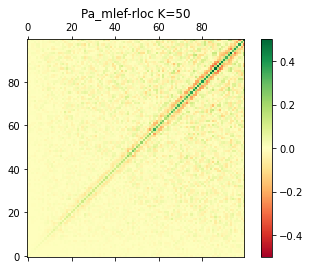

In [172]:
params = {'mlef':('mlef',None,False,False),'mlef-ss':('mlef',2,True,False),'mlef-rg':('mlef',2,False,True),'mlef-rloc':('mlef',0,False,False)}
names2 = ['mlef','mlef-ss','mlef-rg','mlef-rloc']
#names = ['mod','srf']#,'srf-ss','srf-kloc']
#Pa_app_list = [Pam]
from analysis.mlef import Mlef
from analysis.mlef_rloc import Mlef_rloc
for ptype in names2:
    pt, iloc, ss, gain = params[ptype]
    if ptype != 'mlef-rloc':
        analysis = Mlef(pt, N, K, obs, iloc=iloc, lsig=3.0, ss=ss, gain=gain, l_mat=F, l_sqrt=W, calc_dist=calc_dist, calc_dist1=calc_dist1)
    else:
        analysis = Mlef_rloc(pt, K, obs, lsig=3.0, calc_dist=calc_dist, calc_dist1=calc_dist1)
    xb = xf
    pb = Pe
    xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, y[::-1], np.arange(p-1,-1,-1))
    xa_list.append(xa[:,0])
    Pa_app_list.append(Pa)
    fig, ax = plt.subplots()
    mappable = ax.matshow(Pa, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
    ax.invert_yaxis()
    ax.set_title(f'Pa_{ptype} K={K}')
    fig.colorbar(mappable, ax=ax, orientation='vertical')
    if ntest == 0:
        fig.savefig(f'Pa_{ptype}_{K}.pdf')
    plt.show()

In [173]:
method = names + names2
print(method)
#print(names)
xrmse = [0.0]
mse_list = []
corr_list = []
for xam in xa_list:
    #print(xam)
    xrmse.append(np.sqrt(((xam - xt)**2).mean()))
print(xrmse)
for Pa_app in Pa_app_list:
    mse_list.append(mse(Pa_app))
    corr_list.append(corr(Pa_app))
print(mse_list)
print(corr_list)
xrmse_mean.append(xrmse)
mse_mean.append(mse_list)
corr_mean.append(corr_list)
ntest += 1

['mod', 'etkf', 'etkf-ss', 'etkf-rg', 'etkf-kloc', 'po', 'po-mod', 'po-kloc', 'srf', 'srf-ss', 'srf-rg', 'srf-kloc', 'letkf', 'mlef', 'mlef-ss', 'mlef-rg', 'mlef-rloc']
[0.0, 0.6356796654099393, 0.5301046421544666, 0.5301046421544666, 1.364329509891374, 0.6356796654099398, 0.5301046421544665, 0.6288154564729765, 11.555359991481087, 0.7926854251198209, 0.7926854251198209, 18573376.343805697, 0.5319513690067442, 0.8335246976039549, 0.5893715416983251, 0.5893715416983251, 0.6371186050452753]
[0.00011919126270288817, 0.0003542208476384394, 0.00043983498384725107, 0.0002998005954585085, 0.0003542208476384394, 0.00039969694625179155, 0.0003243281987581888, 0.0007199765930168687, 0.07018384027378692, 0.03415056463990375, 0.029268631551662556, 0.07018384027378692, 0.00030306530457313964, 0.00035422084763843154, 0.0004341877943893044, 0.00029980059545850794, 0.00030306530457314]
[0.9450733549591954, 0.6832716758808691, 0.7212275112587728, 0.7586076075237222, 0.6832716758808691, 0.61578515551360

## Check results

In [174]:
print(ntest)
print(np.array(mse_mean).shape)
rmse_m = np.array(xrmse_mean).mean(axis=0)
mse_m = np.array(mse_mean).mean(axis=0)
corr_m = np.array(corr_mean).mean(axis=0)
print(rmse_m)
print(mse_m)
print(corr_m)

10
(10, 17)
[0.00000000e+00 8.15120339e-01 6.33923973e-01 6.33923973e-01
 1.47620306e+00 8.15120339e-01 6.33923973e-01 6.93835626e-01
 6.42845190e+00 9.00746844e-01 9.00746844e-01 2.44646495e+09
 6.61529653e-01 8.81474122e-01 6.19710734e-01 6.19710734e-01
 6.62474272e-01]
[0.00011863 0.00039561 0.00040572 0.00029001 0.00039561 0.00044067
 0.00034544 0.00065685 0.05739157 0.00393384 0.00353815 0.05739157
 0.00029632 0.00039561 0.00046376 0.00028549 0.00029632]
[0.94453732 0.68479411 0.71962597 0.75265079 0.68479411 0.61535768
 0.71874853 0.66453932 0.1646784  0.64071803 0.64398336 0.1646784
 0.73299266 0.68479411 0.7128345  0.75265079 0.73299266]


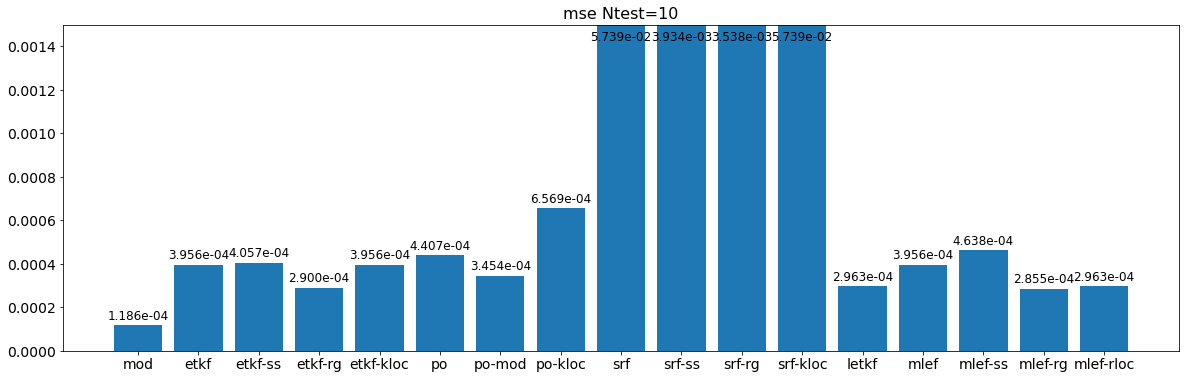

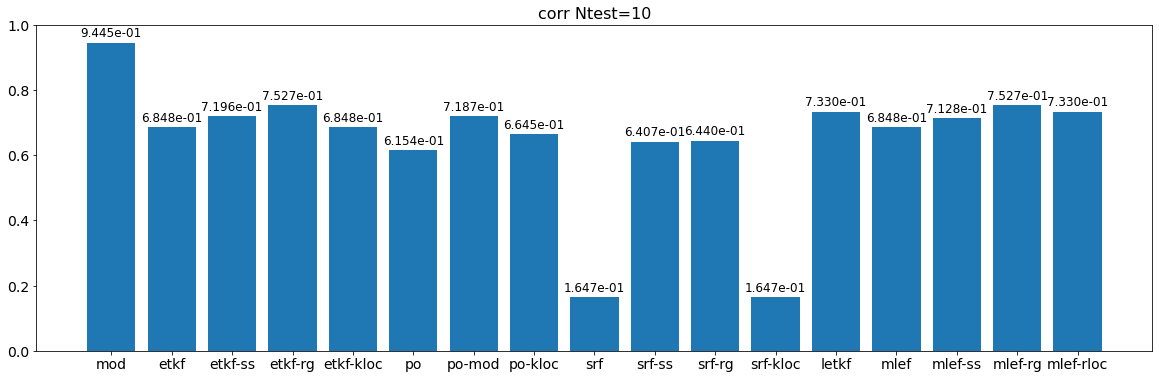

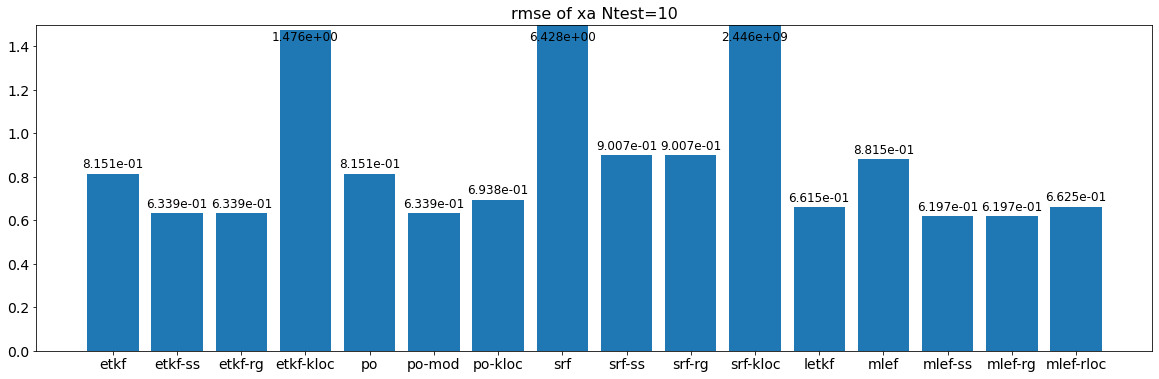

In [175]:
def autolabel(rects, set_lim=None):
    for rect in rects:
        height = rect.get_height()
        if set_lim is not None:
            height_t = min(height, set_lim)
        else:
            height_t = height
        ax.annotate('{:5.3e}'.format(height),
                   xy=(rect.get_x() + rect.get_width() / 2, height_t),
                   xytext=(0, 3),
                   textcoords='offset points',
                   ha='center', va='bottom',
                   fontsize=12)
        
#names = ['mod','ss','rg','po','kloc']
#names = ['mod','etkf','etkf-ss','etkf-rg','etkf-kloc','po','po-mod','po-kloc','srf','srf-ss','srf-rg','srf-kloc','letkf','mlef','mlef-ss','mlef-rg','mlef-rloc']
names = method
fig, ax = plt.subplots(figsize=(20,6))
width = 0.25
xaxis = np.arange(len(Pa_app_list))
#xaxis1 = xaxis - width / 2
#xaxis2 = xaxis + width / 2
rects = ax.bar(names, mse_m)#, label="mse")
#ax.legend()
ax.set_xticks(names)
ax.tick_params(labelsize = 14)
ax.set_ylim(0.0,1.5e-3)
autolabel(rects, set_lim=1.4e-3)
ax.set_title(f"mse Ntest={ntest}", fontdict={'fontsize':16})
fig.savefig('mse.pdf')
plt.show()
fig, ax = plt.subplots(figsize=(20,6))
rects = ax.bar(names, corr_m)#, label="corr")
ax.set_xticks(names)
ax.tick_params(labelsize = 14)
ax.set_ylim(0.0,1.0)
autolabel(rects)
ax.set_title(f"corr Ntest={ntest}", fontdict={'fontsize':16})
fig.savefig('corr.pdf')
plt.show()
fig, ax = plt.subplots(figsize=(20,6))
rects = ax.bar(names[1:], rmse_m[1:])#, label="corr")
ax.set_xticks(names[1:])
ax.tick_params(labelsize = 14)
ax.set_ylim(0.0,1.5)
autolabel(rects, set_lim=1.4)
ax.set_title(f"rmse of xa Ntest={ntest}", fontdict={'fontsize':16})
fig.savefig('rmse.pdf')
plt.show()

## error norm tendency

In [44]:
Nens = [10, 20, 50, 100, 200, 500, 1000]
rs = np.random.RandomState()
errd = np.zeros(len(Nens))
errnd = np.zeros(len(Nens))
nPt = Pt - np.diag(np.diag(Pt))
Ntest = 100
for j, K in zip(np.arange(errd.size),Nens):
    for i in range(Ntest):
        Xf = rs.standard_normal(size=(N,K))
        Xf = sPt @ Xf
        Xf = Xf - Xf.mean(axis=1)[:, None]
        Pe = Xf @ Xf.transpose() / (K-1)
        errnorm = norm(np.diag(Pt) - np.diag(Pe))
        #if np.mod(i, 10) == 0:
        #    print(K,i,errnorm)
        errd[j] += errnorm
        Pe -= np.diag(np.diag(Pe)) - np.diag(np.diag(Pt))
        errnorm = norm(nPt - Pe)
        errnd[j] += errnorm
errd /= Ntest
errnd /= Ntest
print(errd)
print(errnd)

[4.54666053 3.28515271 2.04974714 1.39764678 0.9893927  0.6411916
 0.45391613]
[34.50326565 25.79367496 17.59743138 14.41476607 12.36055522 10.99940219
 10.51034022]


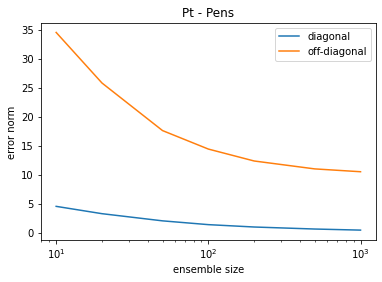

In [46]:
fig, ax = plt.subplots()
ax.plot(Nens, errd, label="diagonal")
ax.plot(Nens, errnd, label="off-diagonal")
ax.set_ylabel("error norm")
ax.set_xlabel("ensemble size")
ax.set_xscale("log")
ax.set_title("Pt - Pens")
ax.legend()
plt.show()